# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки

* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

Целевой признак

* `Price` — цена (евро)

## Подготовка данных

In [124]:
# импорт библиотек

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression


In [125]:
# считываем файл и выводим первичную информацию
data = pd.read_csv('autos.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В данных есть пропуски.

In [126]:
# выведем базовые статистики
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В числовых данных присутвуют выбросы. Посмотирим на нулевуе значения, столбце `Price` является целевым признаком. 

In [127]:
print('Кол-во нулевых значений:', data[data['Price'] <= 10].count())

Кол-во нулевых значений: DateCrawled          12112
Price                12112
VehicleType           7824
RegistrationYear     12112
Gearbox               9181
Power                12112
Model                 9638
Kilometer            12112
RegistrationMonth    12112
FuelType              8159
Brand                12112
Repaired              6084
DateCreated          12112
NumberOfPictures     12112
PostalCode           12112
LastSeen             12112
dtype: int64


Около 2-3% данных с нулевыми значениями, удалим нулевые значения у целевого признака.

In [128]:
data = data.query('Price > 1')
print('Кол-во нулевых значений:', data[data['Price'] == 0].count())

Кол-во нулевых значений: DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64


In [129]:
# посмотрим на данные
data.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [130]:
# функция отображения графиков
def data_analize(data, describe, column_name, bins, x_name, y_name, rotate):
    
    if describe:
        print('Кол-во пустых значений:',data[data[column_name].isna()].shape[0])
        display(data[column_name].describe())
    
    if rotate:
        plt.xticks(rotation=rotate)
    
    plt.xlabel(x_name)
    plt.ylabel(y_name)

    data[column_name].hist(bins=bins, grid=True)
    
    plt.show()

Кол-во пустых значений: 0


count    342408.000000
mean       4570.936006
std        4514.894622
min           2.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

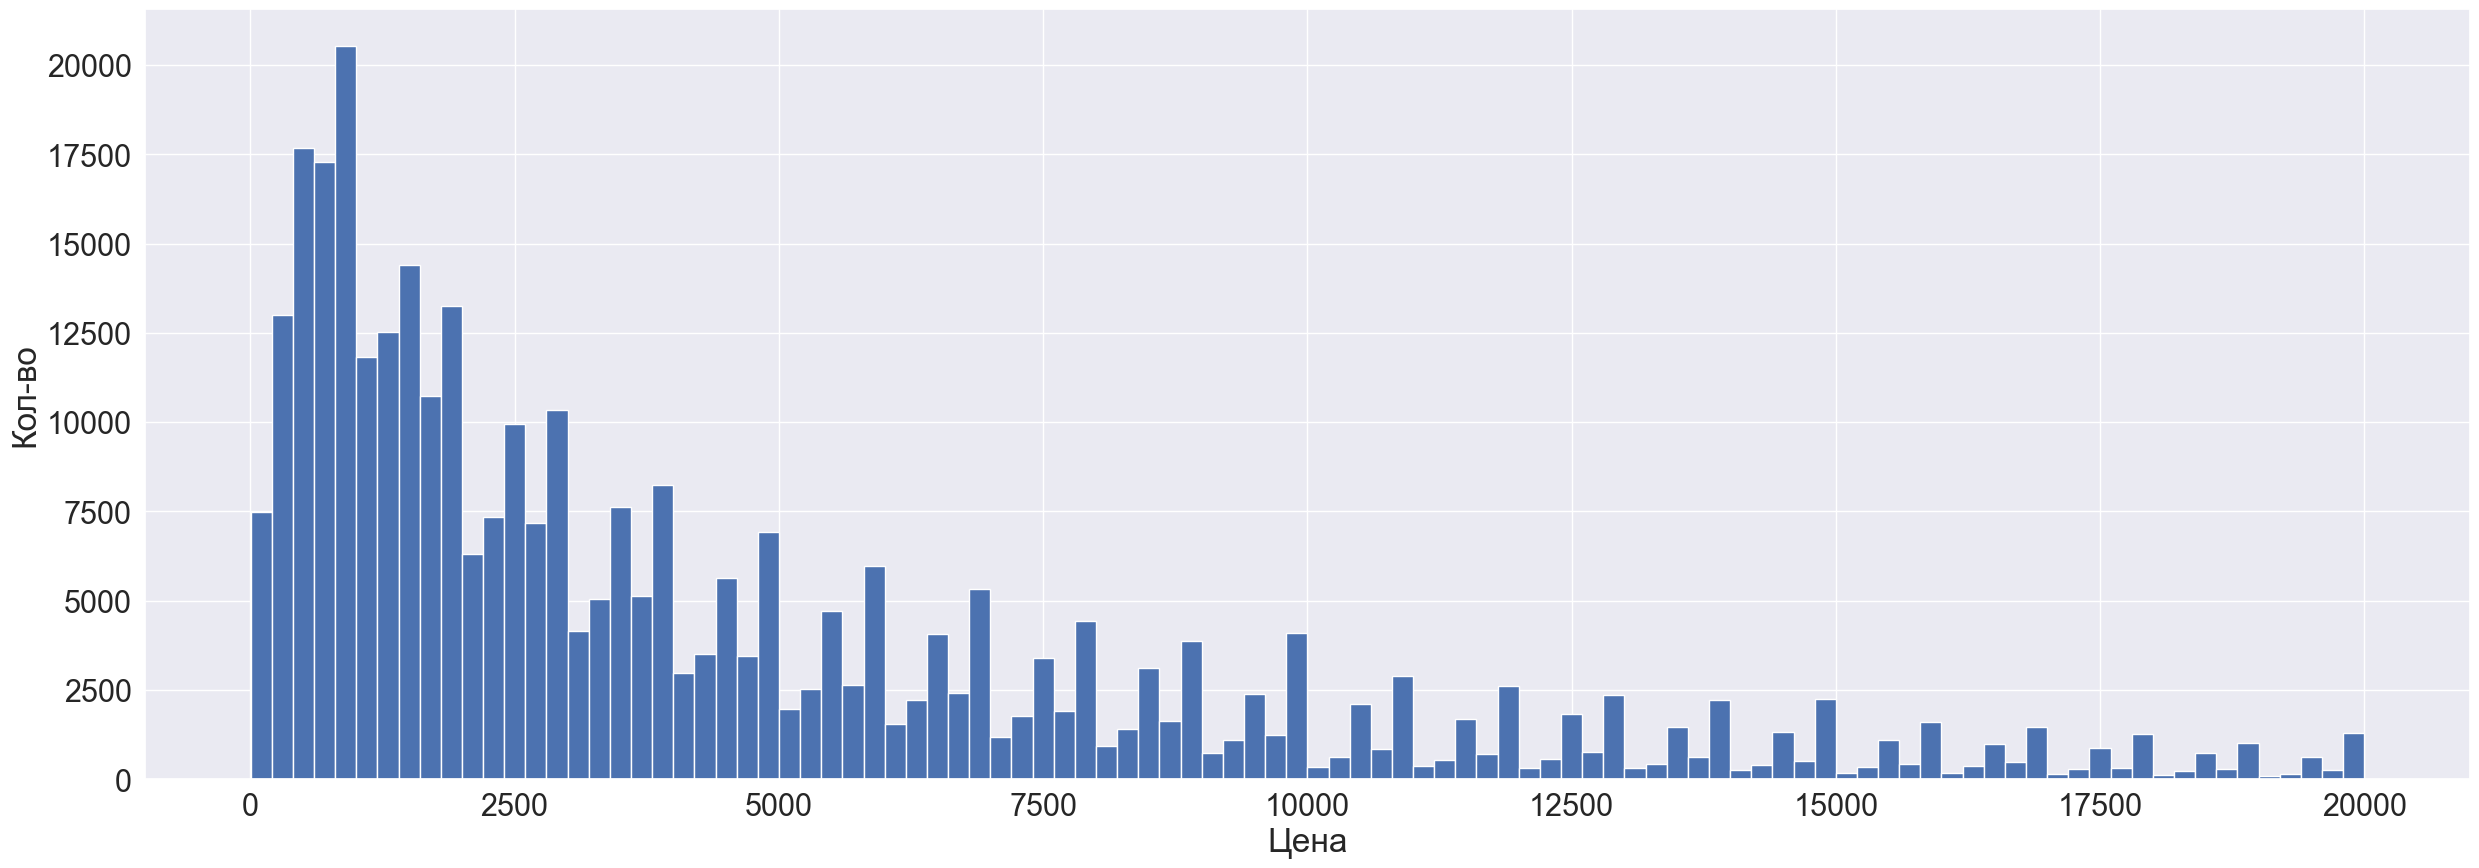

In [131]:
data_analize(data, 1, 'Price', 100, 'Цена', 'Кол-во', 0) 

В Столбеце `Price` третий квантил и максимальное значение имеют большой разброс, посмотрим на  кол-во строк после третьего квантиля.

In [132]:
data.query('Price > 19500')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
172,2016-03-07 12:38:19,19750,convertible,2006,manual,305,mustang,50000,7,petrol,ford,no,2016-03-07 00:00:00,0,38350,2016-03-12 20:18:29
484,2016-03-31 23:52:32,19900,bus,2009,manual,150,viano,90000,5,gasoline,mercedes_benz,no,2016-03-31 00:00:00,0,59348,2016-04-07 03:17:20
1360,2016-03-07 09:53:50,19850,sedan,2013,auto,150,golf,60000,6,gasoline,volkswagen,no,2016-03-07 00:00:00,0,57078,2016-03-20 16:48:15
1515,2016-03-09 10:18:36,20000,sedan,2010,auto,239,a6,150000,5,gasoline,audi,no,2016-03-07 00:00:00,0,56567,2016-03-30 19:17:04
1586,2016-04-03 21:41:49,20000,sedan,2014,auto,184,leon,40000,4,gasoline,seat,no,2016-04-03 00:00:00,0,30655,2016-04-05 22:18:39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353096,2016-04-05 00:42:58,19900,sedan,2010,auto,204,e_klasse,80000,12,gasoline,mercedes_benz,no,2016-04-04 00:00:00,0,51491,2016-04-07 08:15:36
353590,2016-03-14 00:36:42,19950,wagon,2009,manual,265,other,125000,1,petrol,audi,no,2016-03-14 00:00:00,0,59872,2016-03-20 21:45:10
354045,2016-03-22 20:48:48,20000,coupe,2006,auto,476,other,125000,7,petrol,mercedes_benz,no,2016-03-22 00:00:00,0,38118,2016-03-24 05:16:02
354178,2016-03-14 00:48:36,19990,small,2014,auto,185,a1,10000,2,petrol,audi,no,2016-03-13 00:00:00,0,42659,2016-04-07 03:17:51


Кол-во пустых значений: 0


count    342408.000000
mean       2004.074061
std          77.247670
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

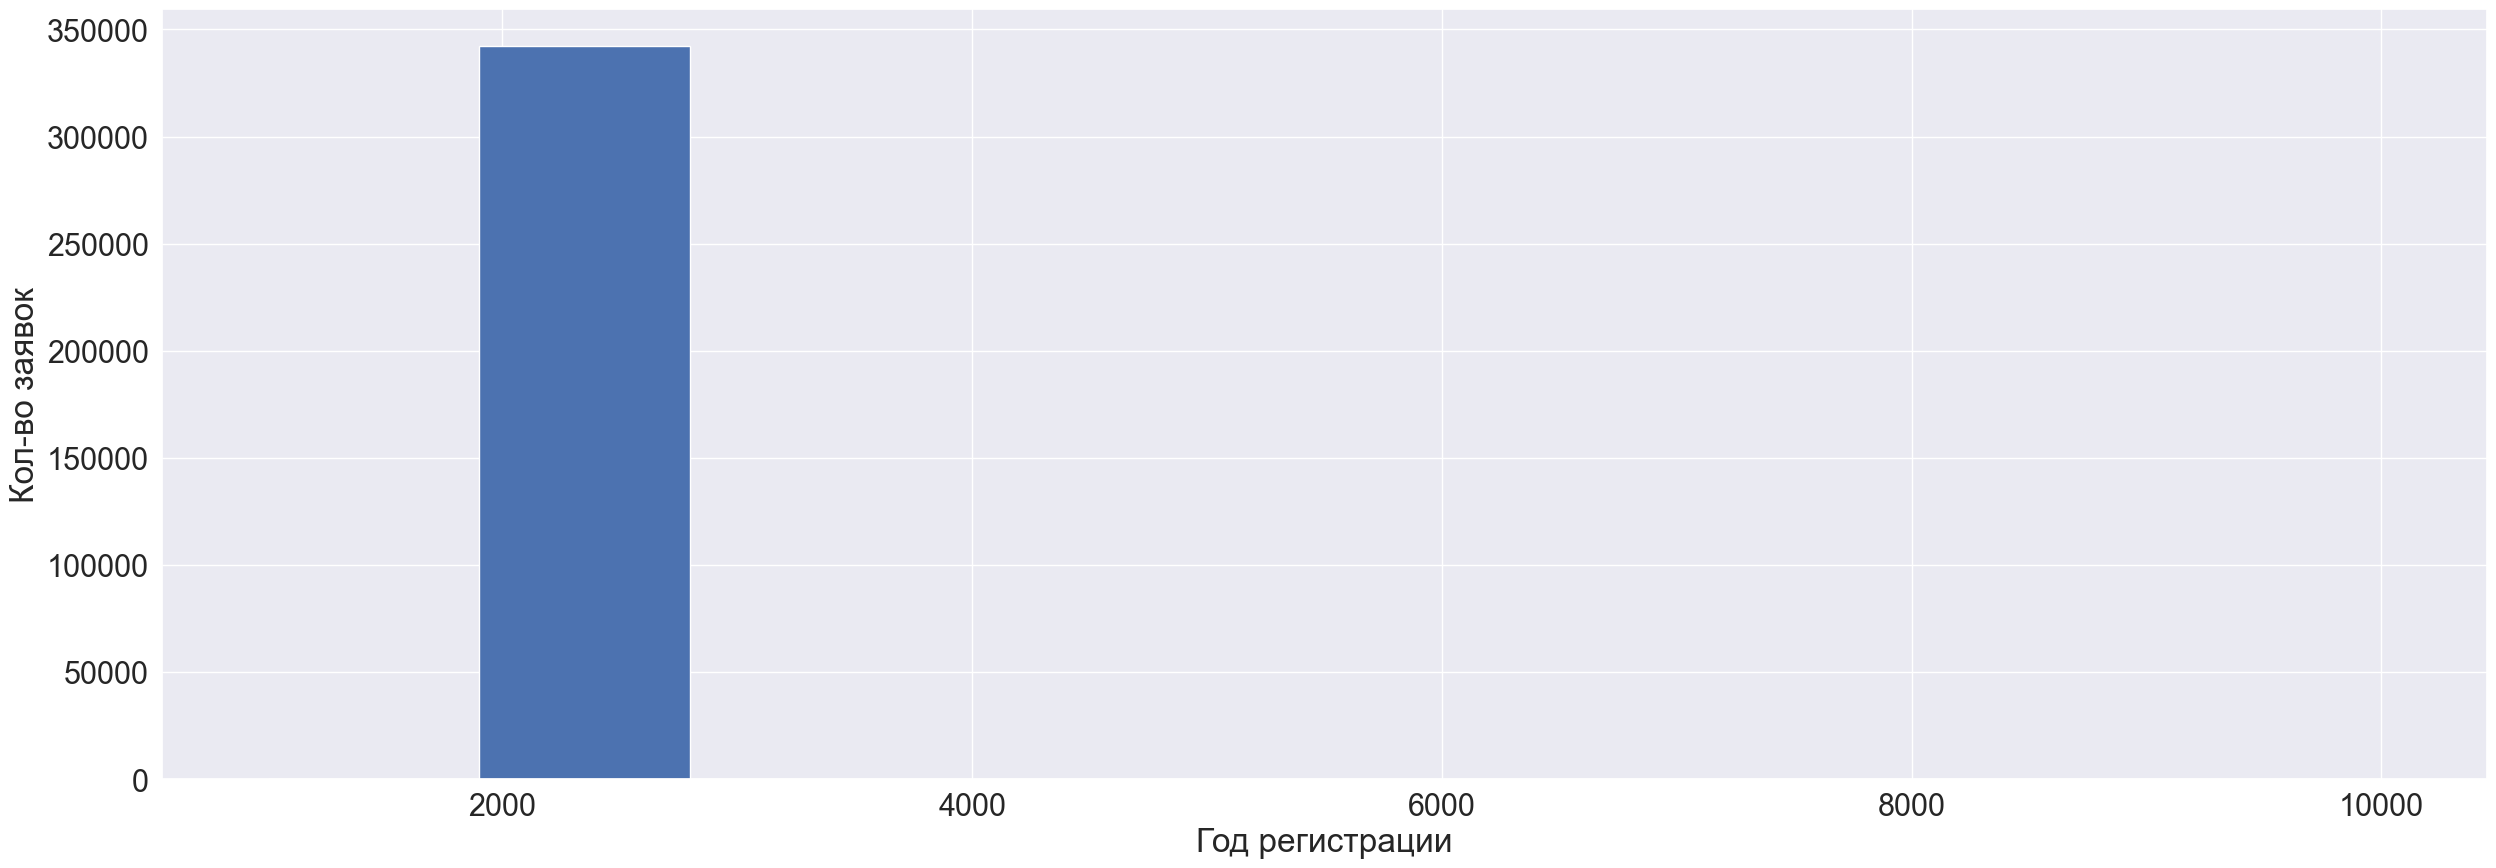

In [133]:
data_analize(data, 1, 'RegistrationYear', 10, 'Год регистрации', 'Кол-во заявок', 0) 

В столбце `RegistrationYear` присутствуют выбросы.

In [134]:
# отсавим данные от 1989 и до 2023
data = data.query('RegistrationYear > 1989 and RegistrationYear <= 2016')

Кол-во пустых значений: 0


count    319874.000000
mean       2003.230497
std           5.601980
min        1990.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

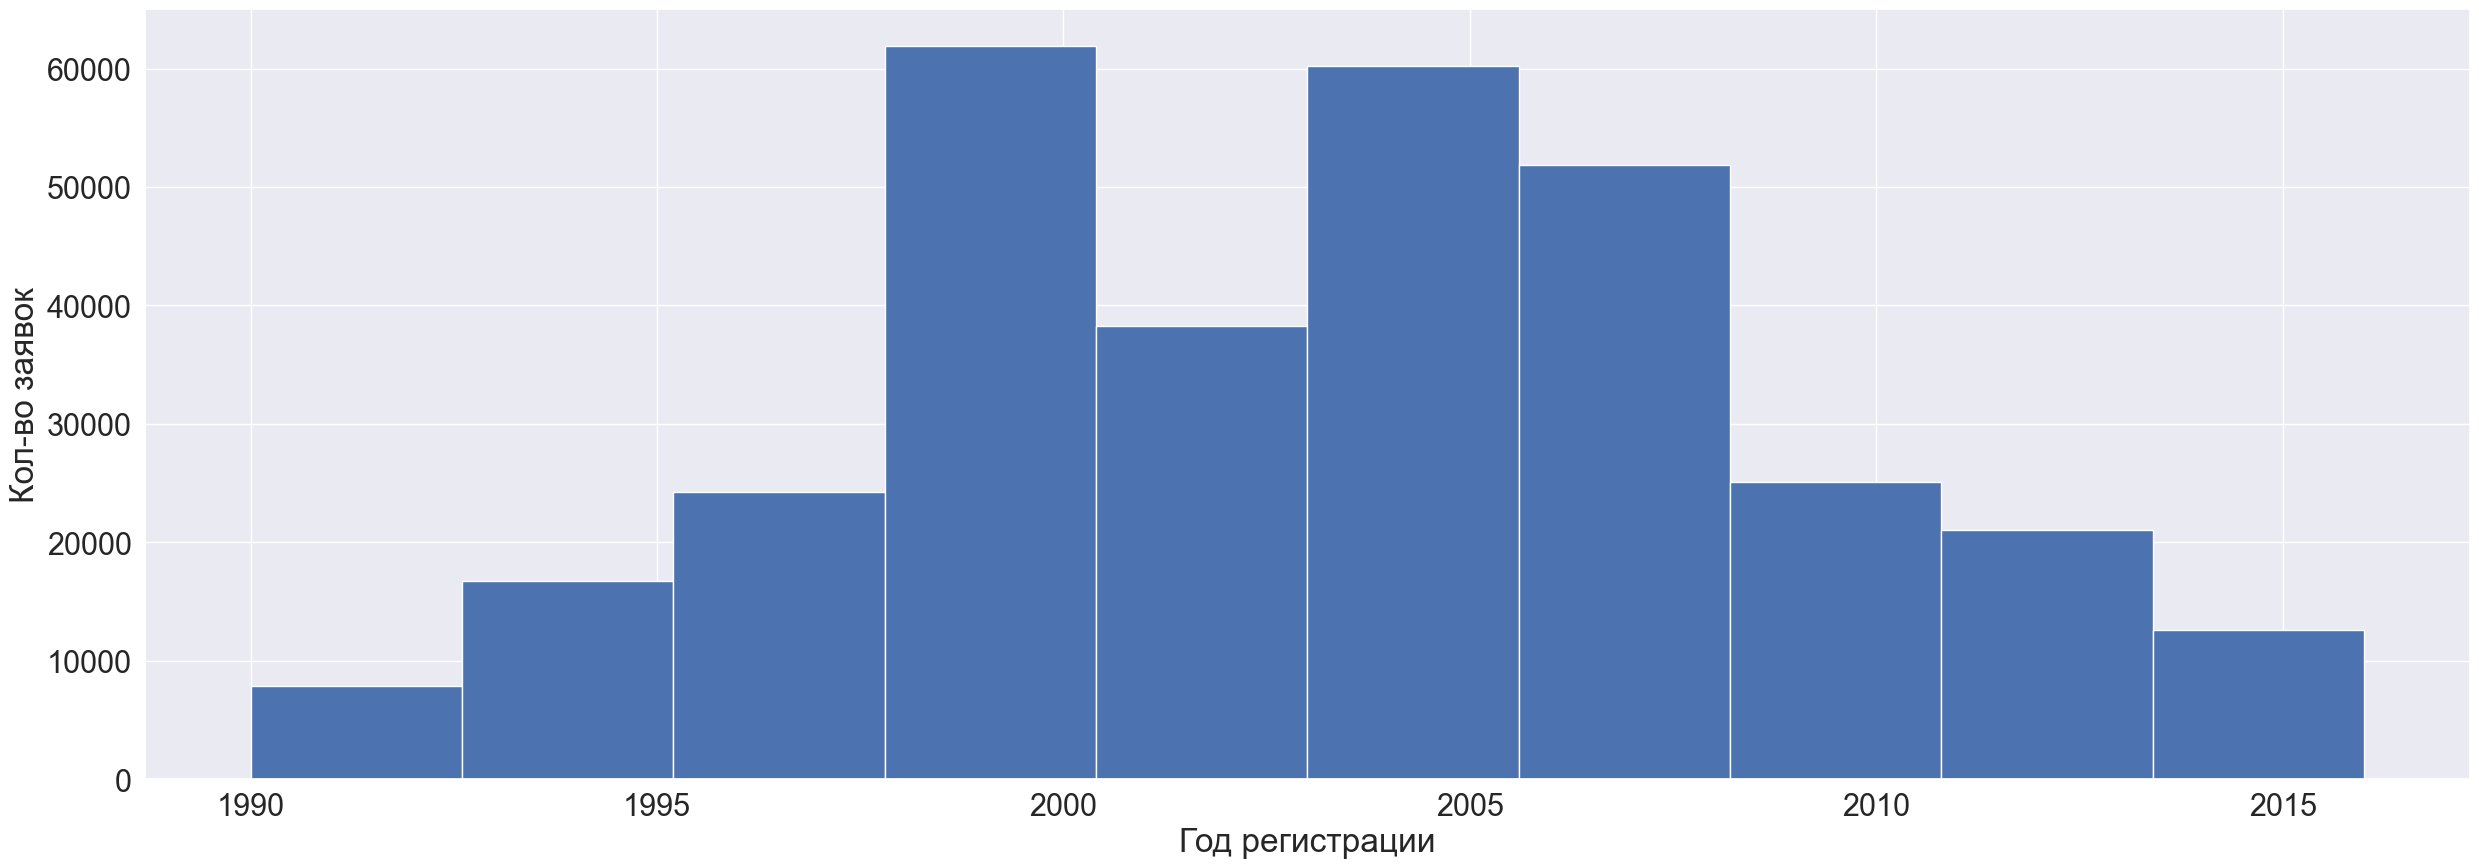

In [135]:
data_analize(data, 1, 'RegistrationYear', 10, 'Год регистрации', 'Кол-во заявок', 0) 

Данные стали похожи на стандартное распределение.

Кол-во пустых значений: 0


count    319874.000000
mean        112.695127
std         182.197759
min           0.000000
25%          73.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

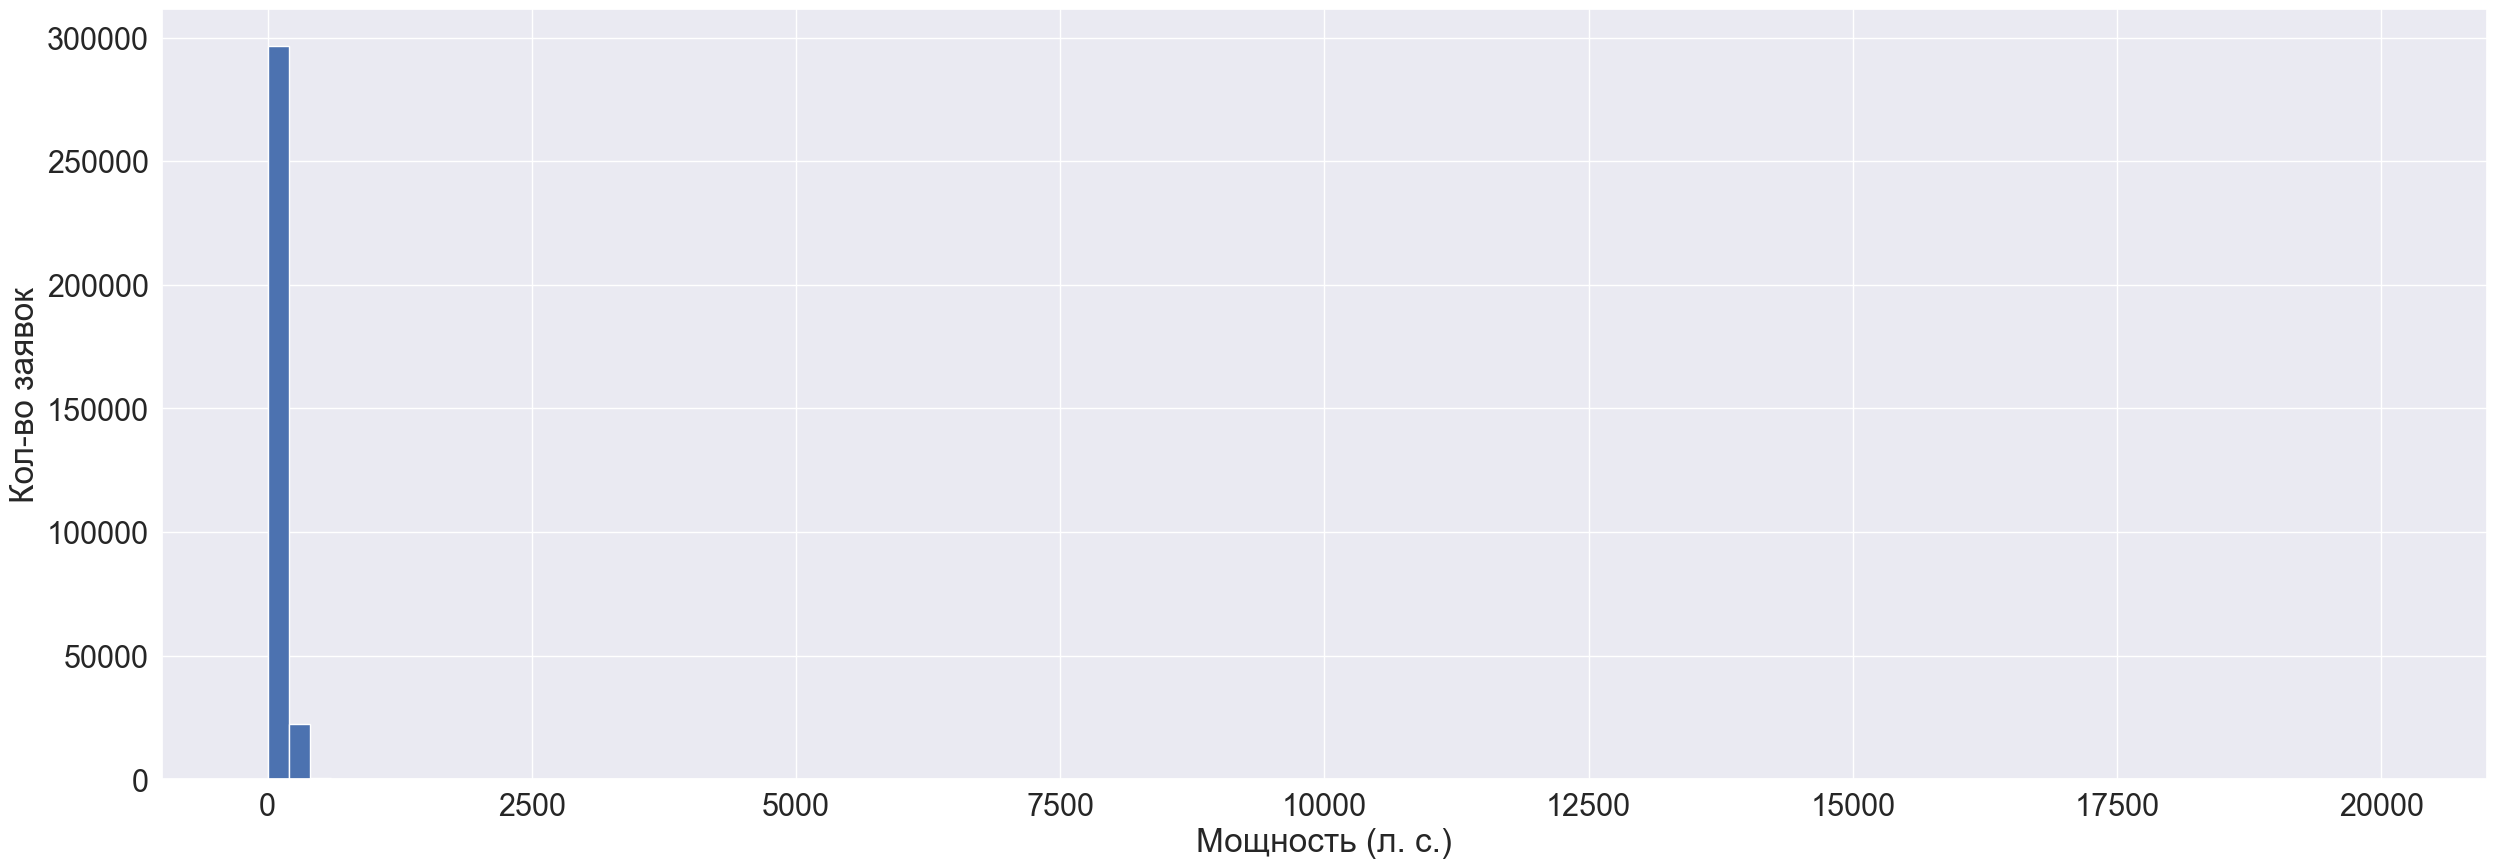

In [136]:
data_analize(data, 1, 'Power', 100, 'Мощность (л. с.)', 'Кол-во заявок', 0) 

В столбце `Power` присутствуют нулевые значения, что бы заполнить нулевые значения сгруппируем данные по модели, бренду и типу топлива.

In [137]:
# проверим столбцы на пустоту модель, бренд и ип топлива
print('[Model] Кол-во пустых строк:', data[data['Model'].isna()]['Model'].shape[0])
print('[Brand] Кол-во пустых строк:', data[data['Brand'].isna()]['Brand'].shape[0])
print('[FuelType] Кол-во пустых строк:', data[data['FuelType'].isna()]['FuelType'].shape[0])

[Model] Кол-во пустых строк: 14073
[Brand] Кол-во пустых строк: 0
[FuelType] Кол-во пустых строк: 22507


Перед заполнением столбца `Power` необходимо заполнить пропуски у этих категорий.

In [138]:
# заполним пропуски у категориальных переменных

data['Model'] = data['Model'].fillna('unknown')
data['FuelType'] = data['FuelType'].fillna('unknown')

In [139]:
# сгруппируем категориальные переменные для получения медианы
# заполним нули и пустые значения медианой

data_fill_power = data.groupby(['Brand', 'Model', 'FuelType'])['Power'].median()
median = data_fill_power.reset_index()['Power'].median()

filter = (data['Power'] == 0) | (data['Power'].isna())    
data.loc[filter, 'Power'] = data[filter].apply(
    lambda row: median if data_fill_power[row['Brand']][row['Model']][row['FuelType']] <= 0 else 
    data_fill_power[row['Brand']][row['Model']][row['FuelType']], axis=1)


In [140]:
# отсечем данные где двигатель > 450 л.с
data = data.query('Power < 450')

Кол-во пустых значений: 0


count    319341.000000
mean        118.784588
std          51.884485
min           1.000000
25%          75.000000
50%         110.000000
75%         144.000000
max         449.000000
Name: Power, dtype: float64

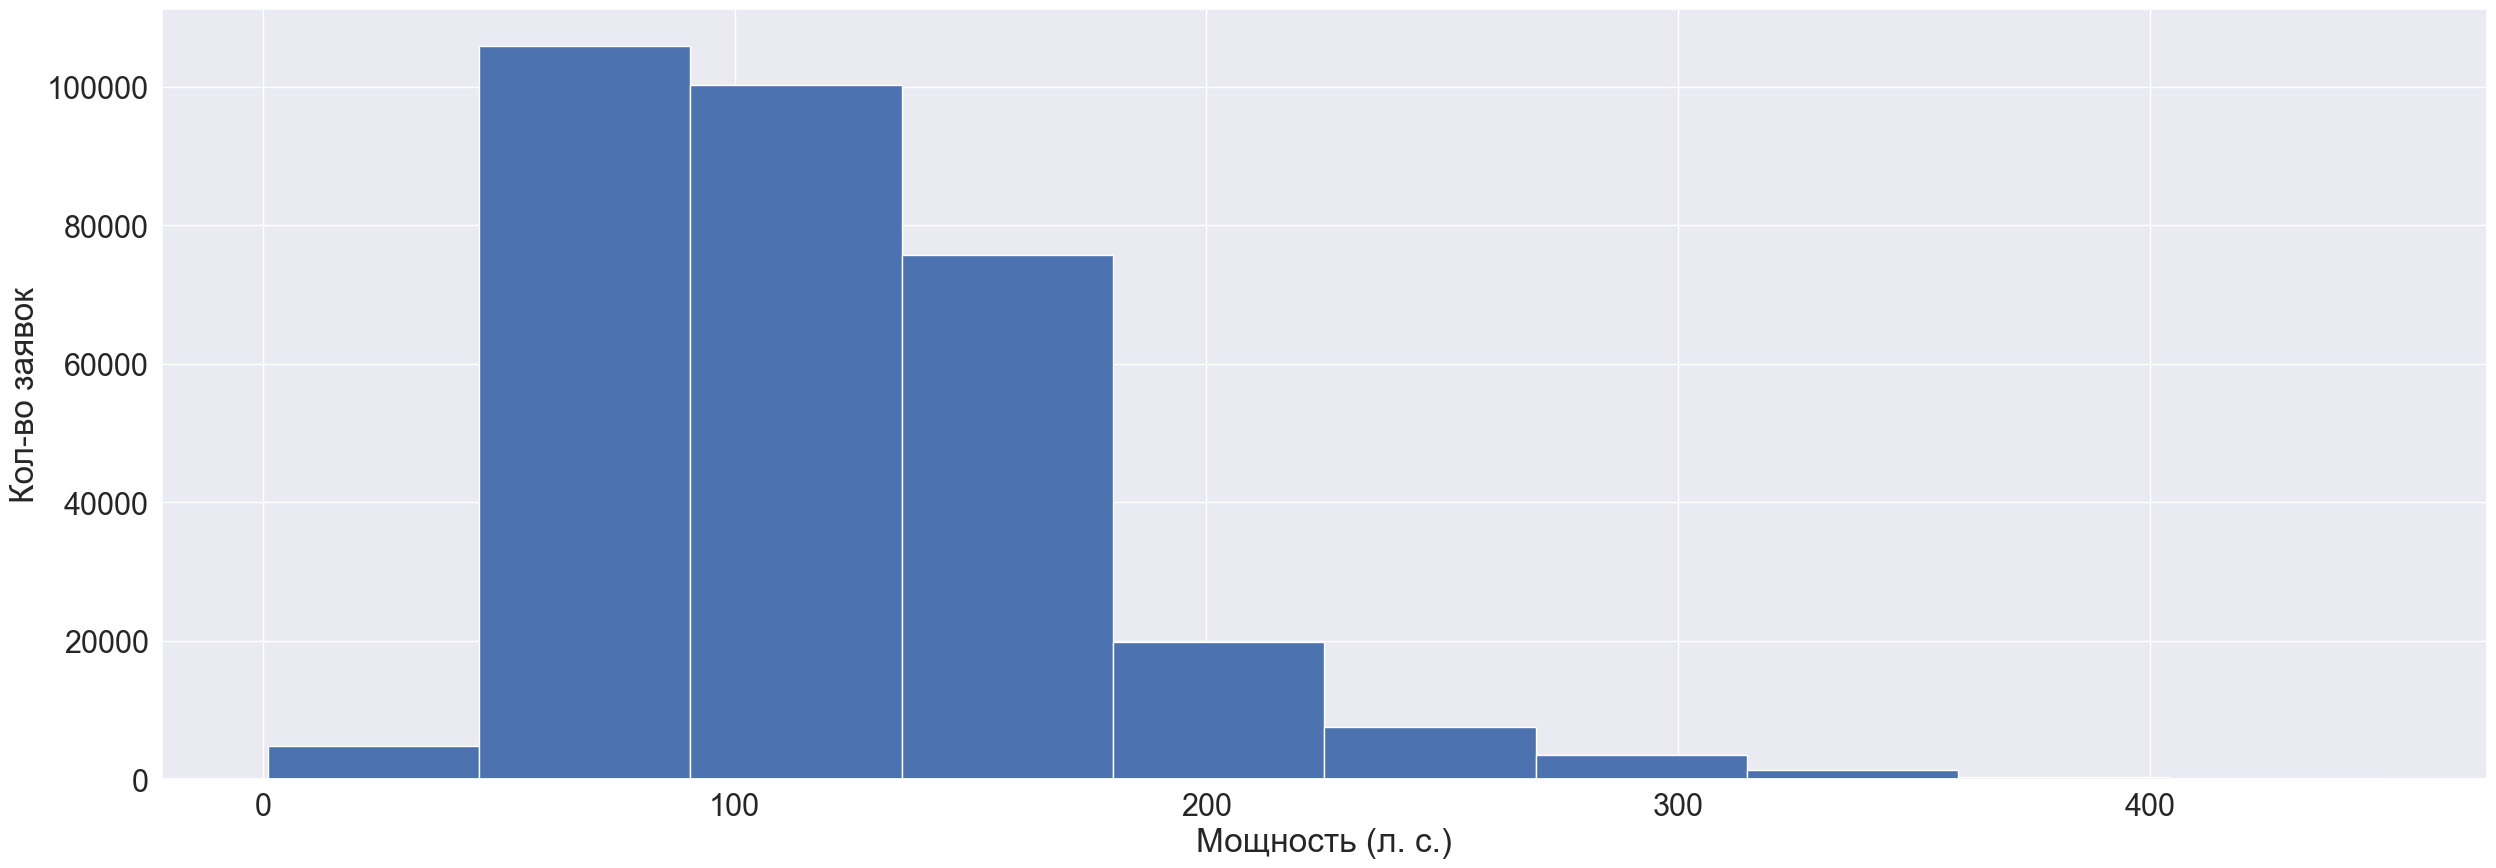

In [141]:
data_analize(data, 1, 'Power', 10, 'Мощность (л. с.)', 'Кол-во заявок', 0) 

Распределение смещено вправо. Больше всего машин выставлено на продажу с мошьностью двигателя в районе 100 л.с.

Кол-во пустых значений: 0


count    319341.000000
mean     128817.502294
std       36844.569220
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

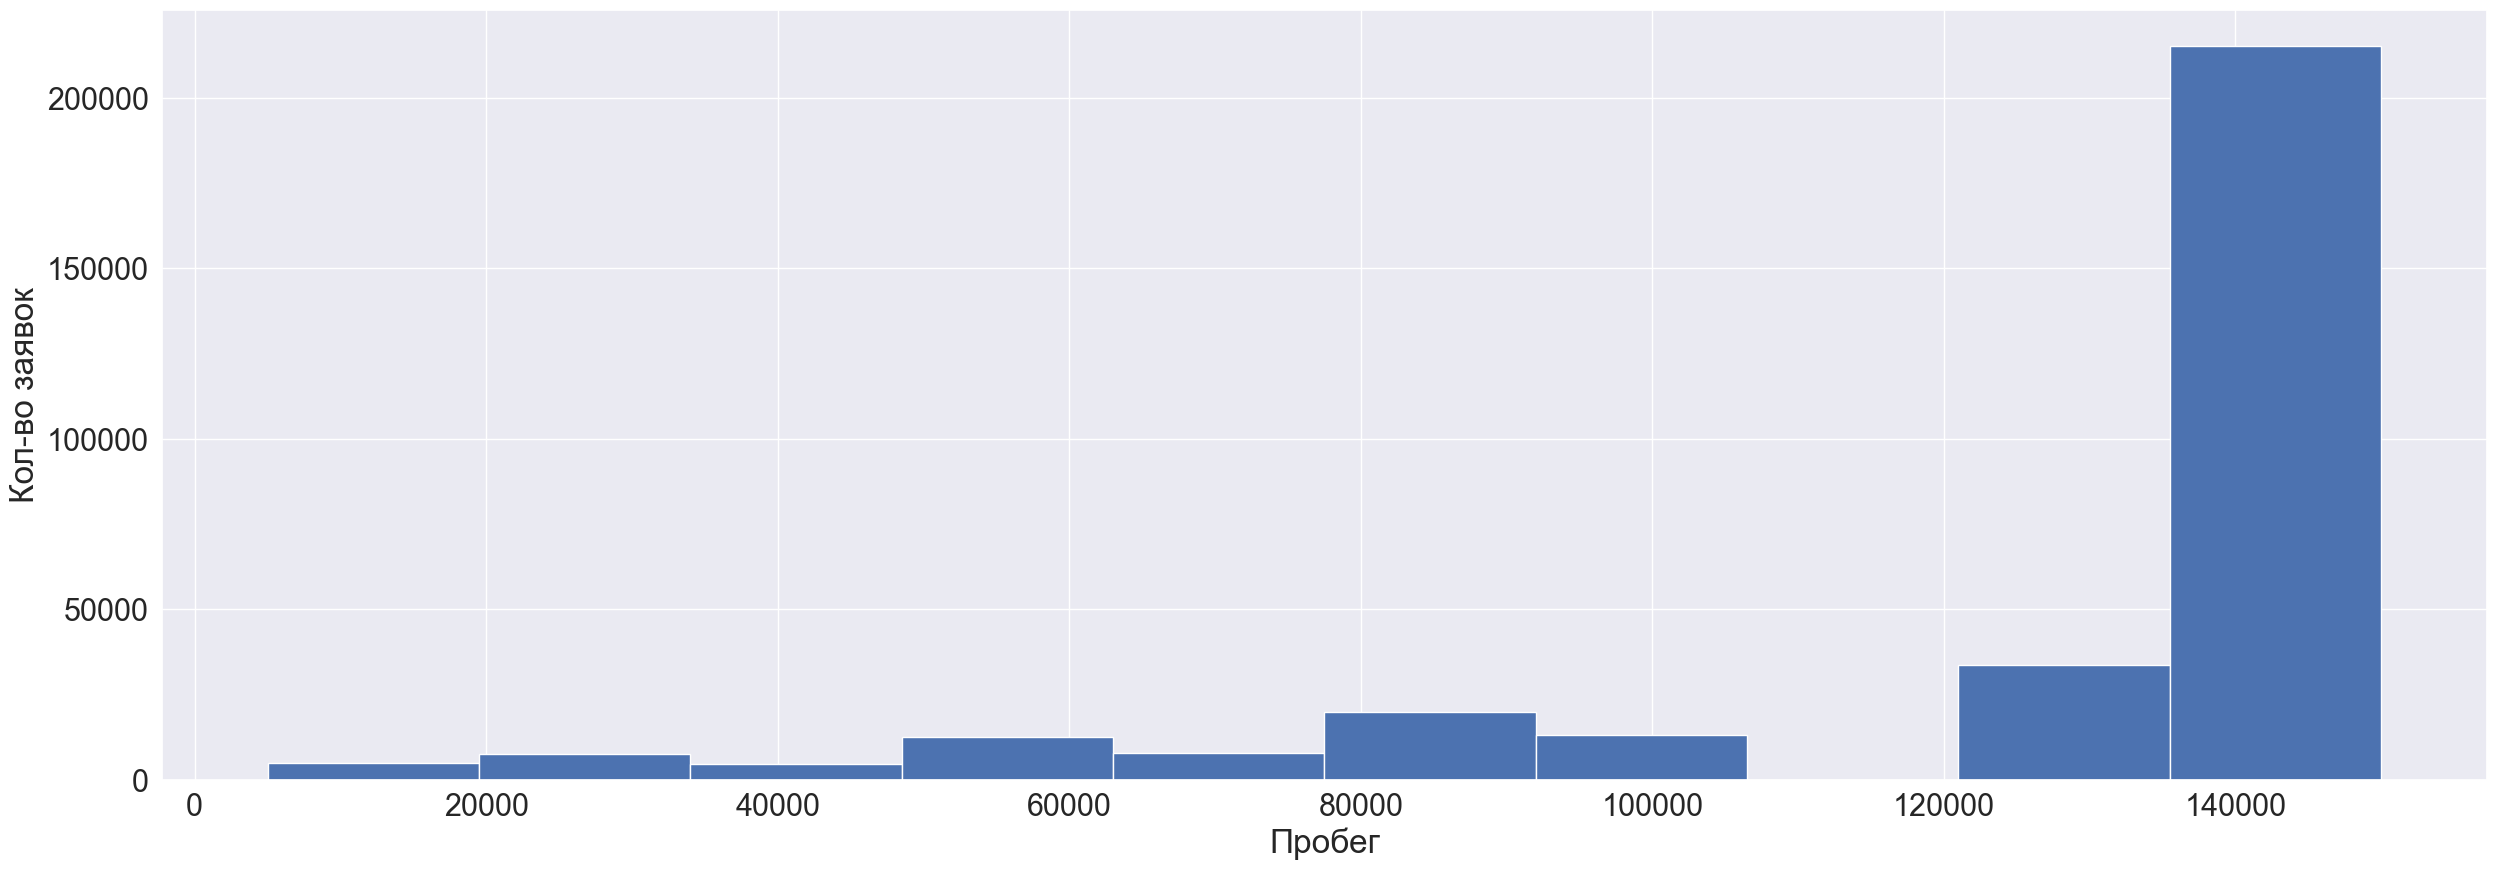

In [142]:
data_analize(data, 1, 'Kilometer', 10, 'Пробег', 'Кол-во заявок', 0) 

В столбце `Kilometer` большинство машин с пробегом более 130 тыс.

Кол-во пустых значений: 0


count    319341.000000
mean          5.853796
std           3.672761
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64

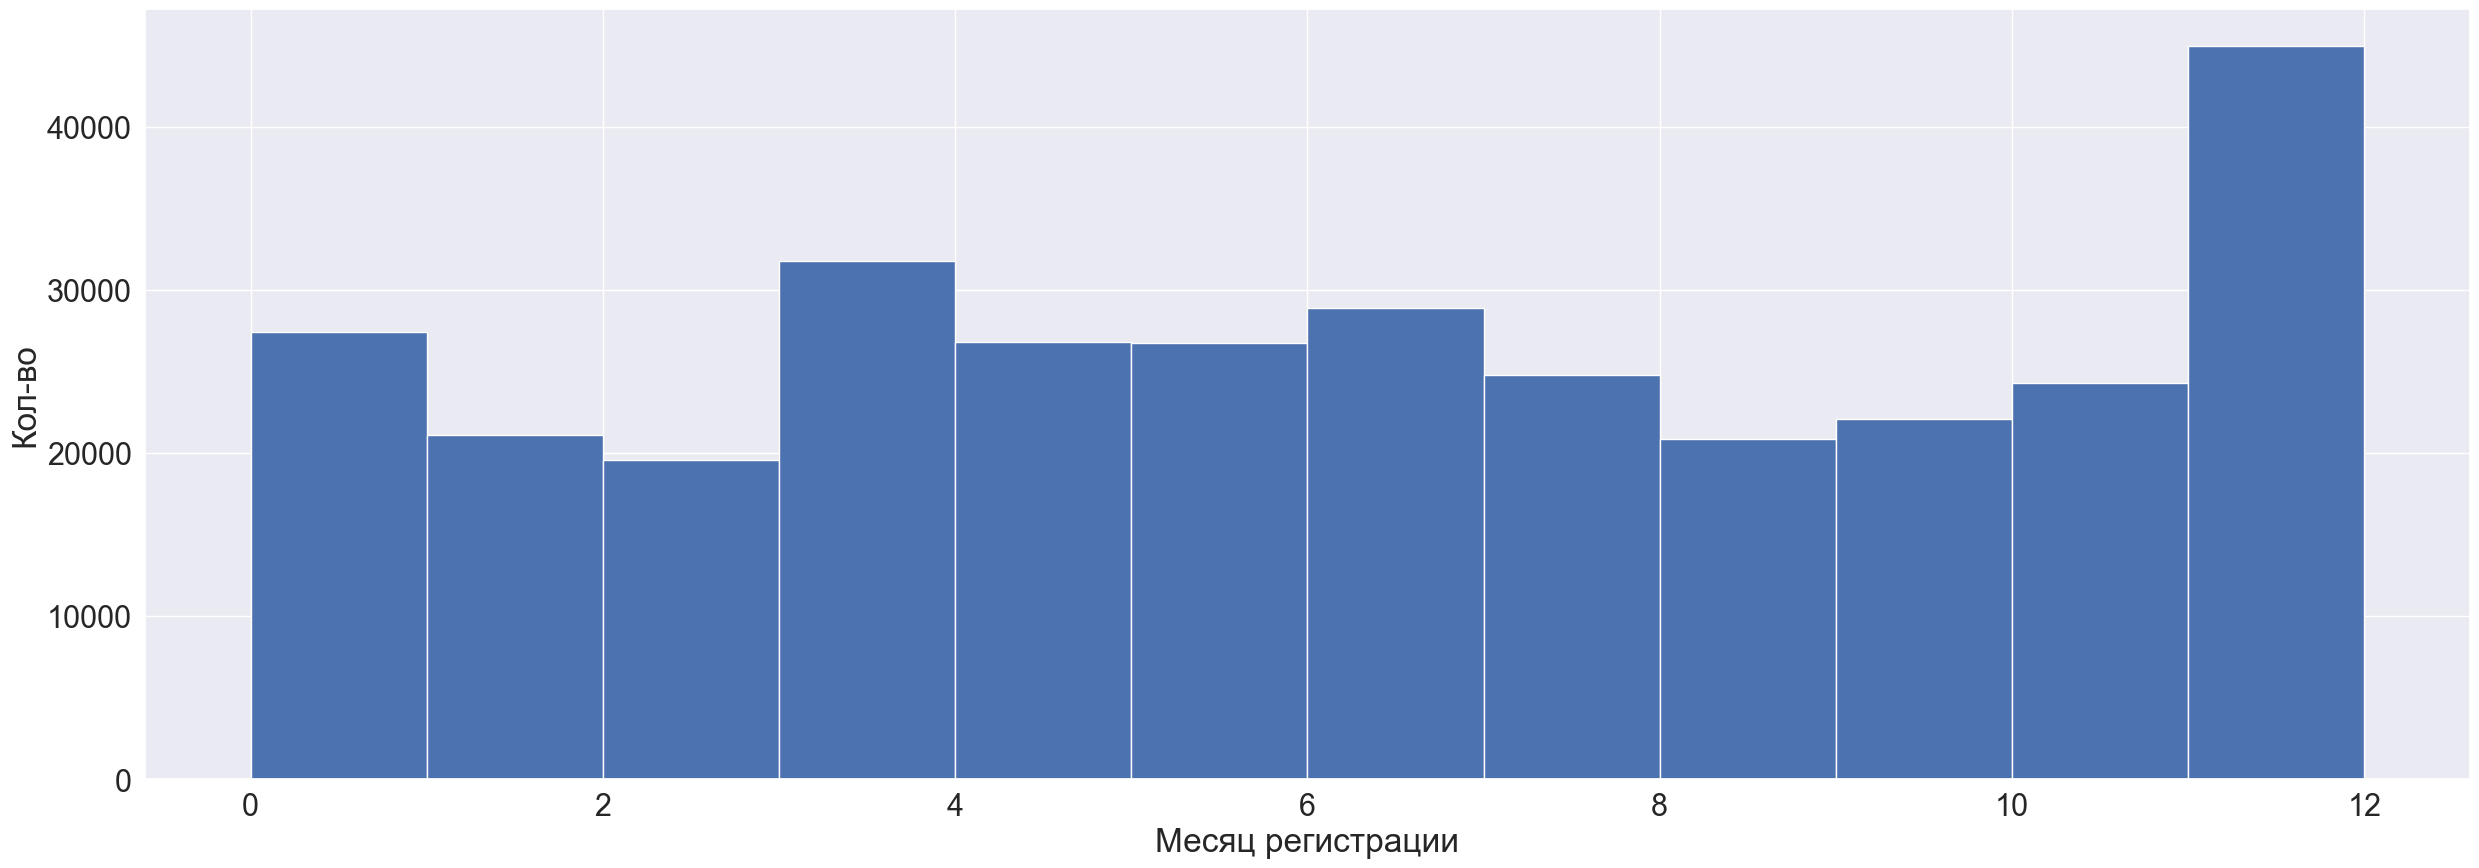

In [143]:
data_analize(data, 1, 'RegistrationMonth', 12, 'Месяц регистрации', 'Кол-во', 0)

В столбце `RegistrationMonth` месяц регистрации нулевой, т.е мы получаем значения от 0 до 12, в итоге 13 месяцев.

В столбце `NumberOfPictures` полностью нулевые значения, его можно удалить.

Кол-во пустых значений: 0


count    319341.000000
mean      50795.756780
std       25721.723145
min        1067.000000
25%       30519.000000
50%       49624.000000
75%       71296.000000
max       99998.000000
Name: PostalCode, dtype: float64

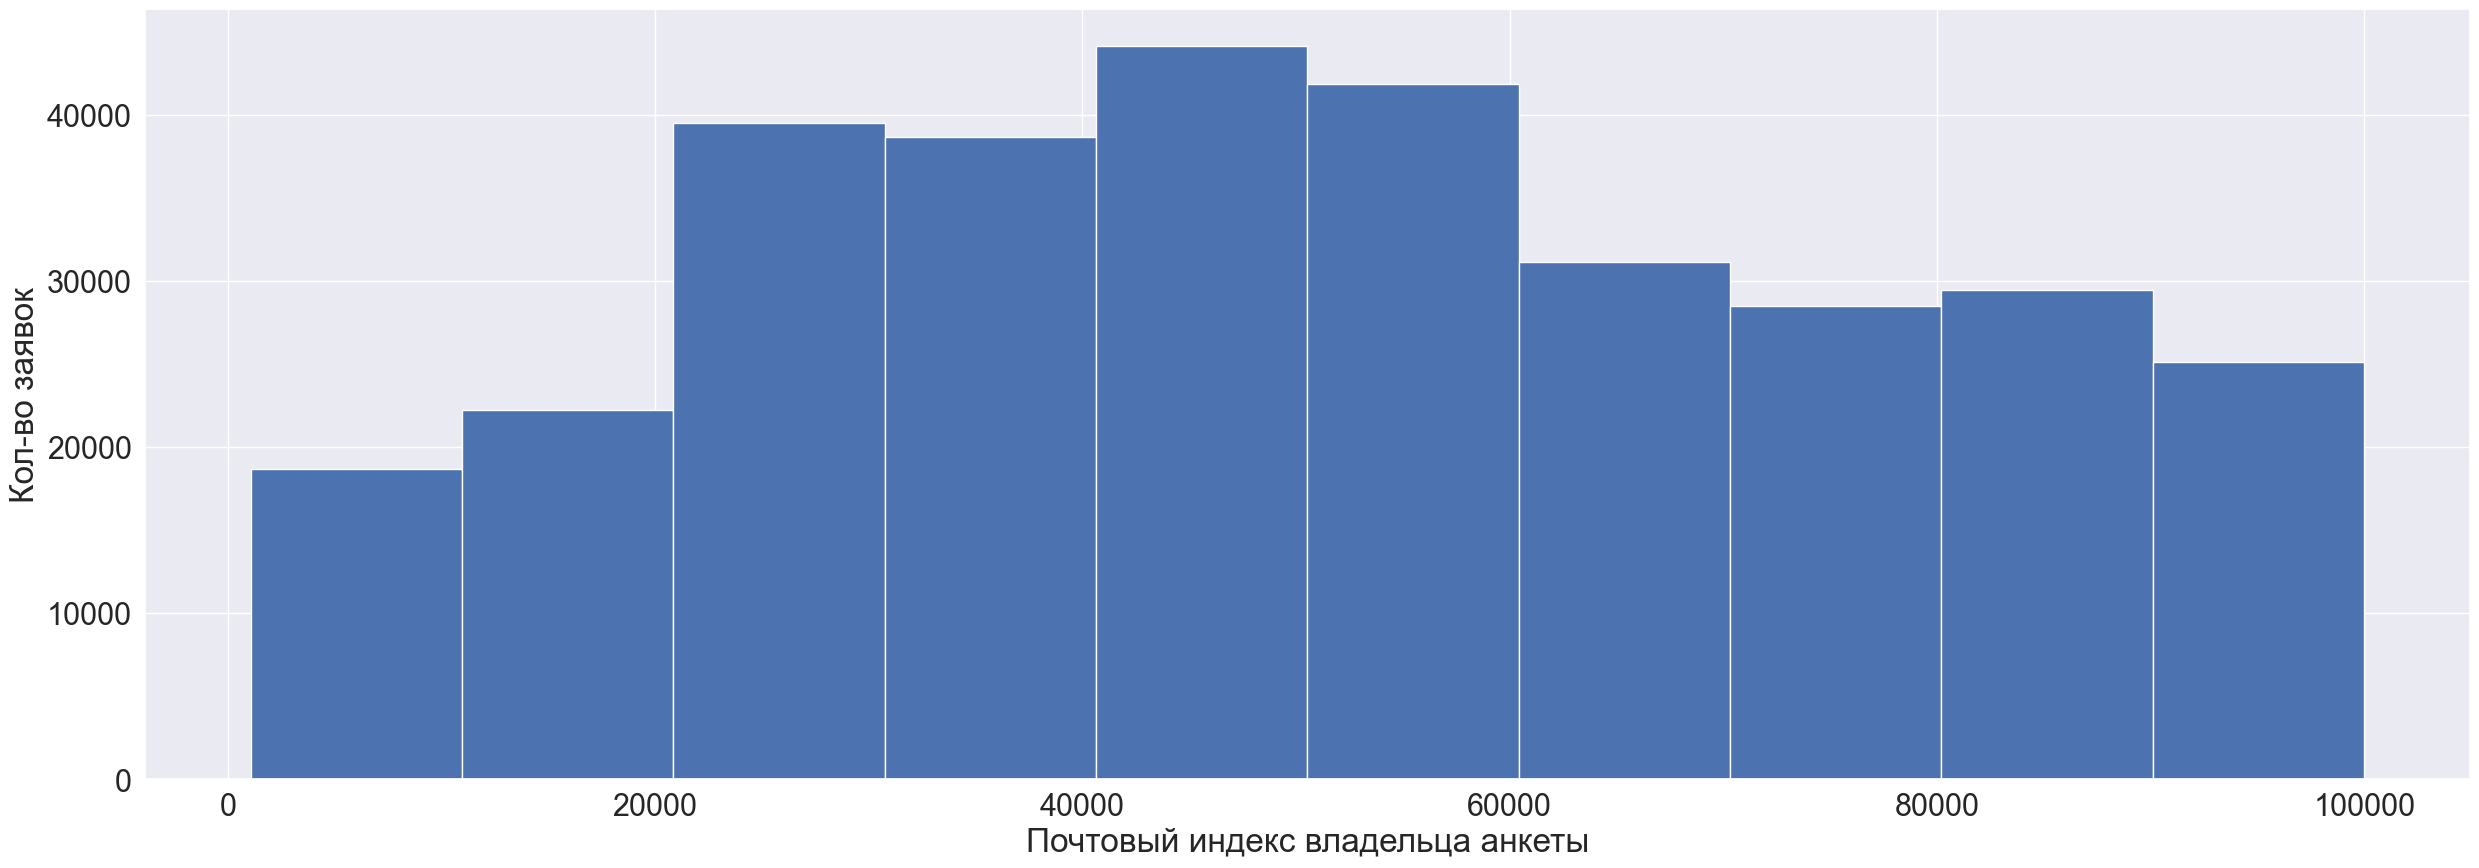

In [144]:
data_analize(data, 1, 'PostalCode', 10, 'Почтовый индекс владельца анкеты', 'Кол-во заявок', 0)

В данном столбце трудно говорить о выбросах, но возможно есть зависимость целевого признака от почтового индекса.

Кол-во пустых значений: 18809


count     300532
unique         8
top        sedan
freq       85775
Name: VehicleType, dtype: object

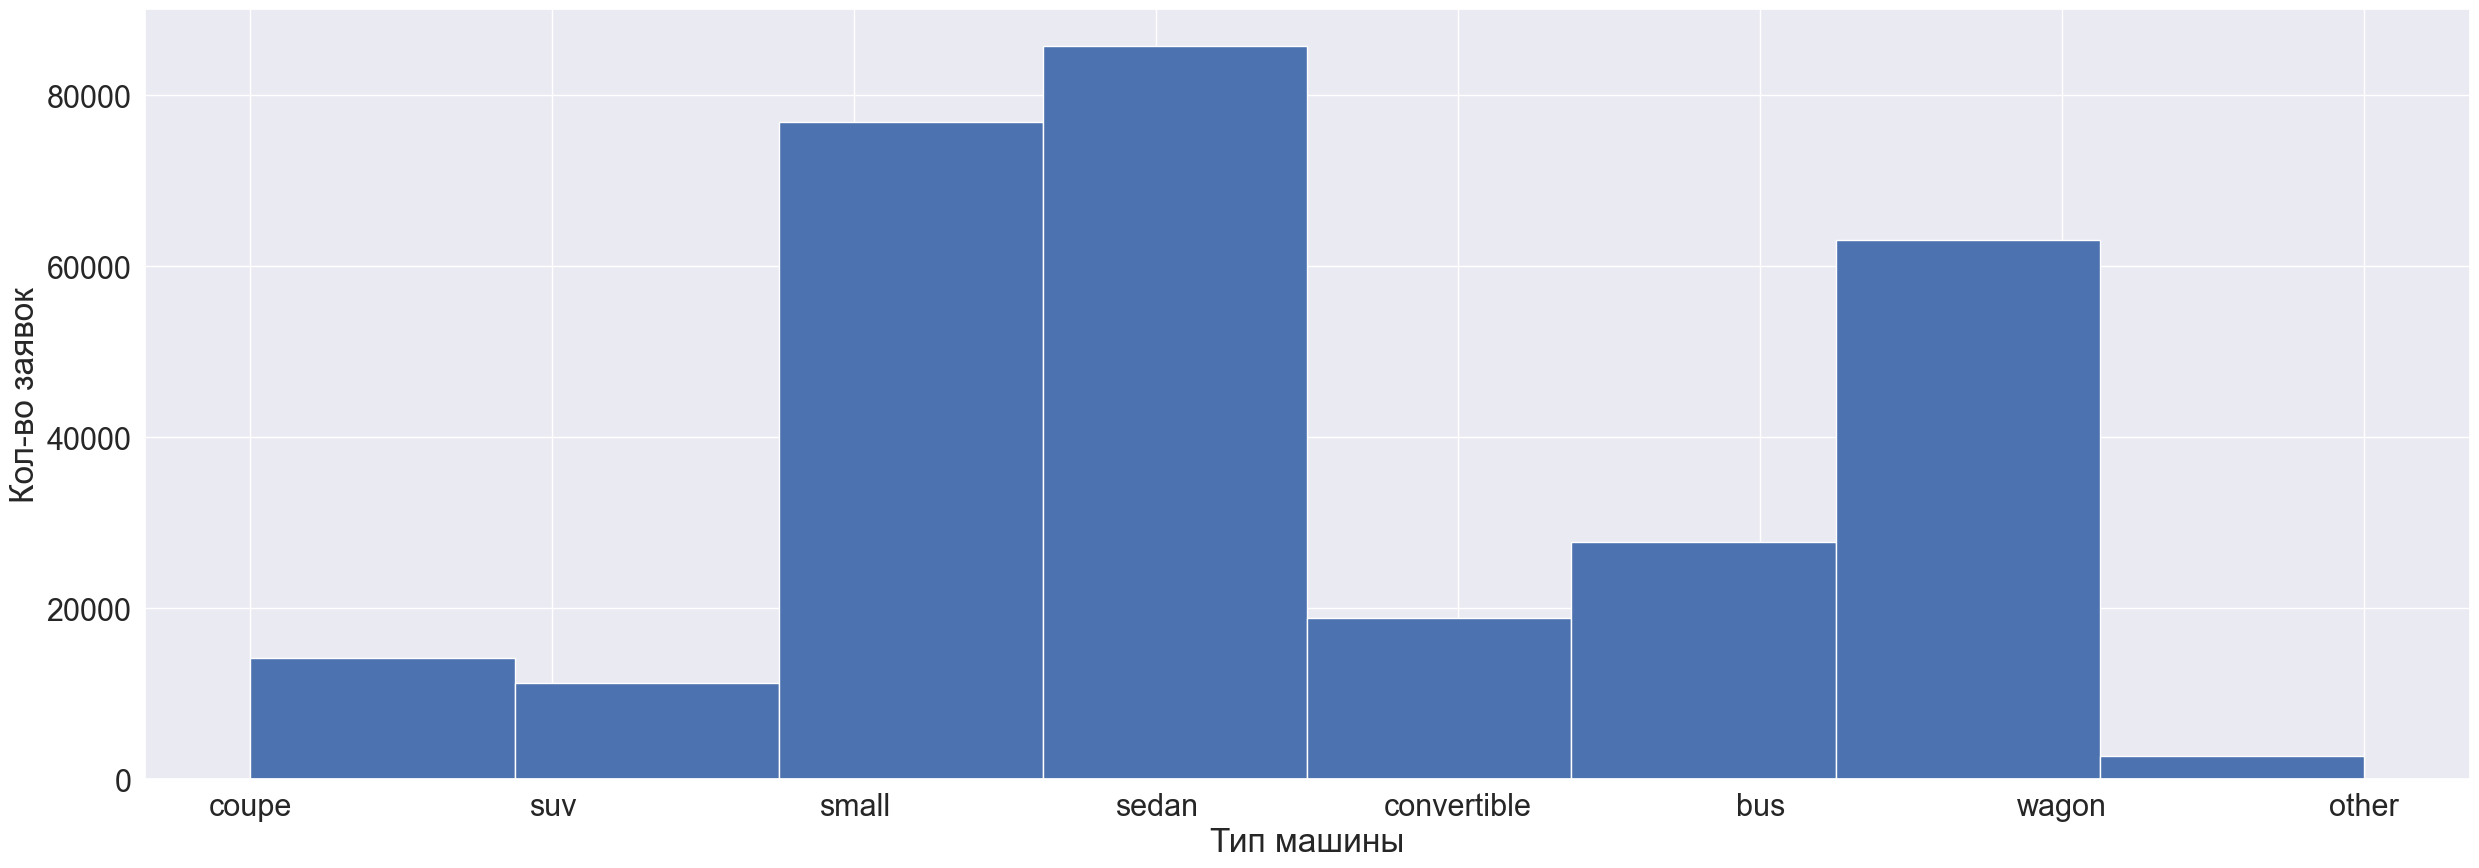

In [145]:
# заполним пропуски и выведем гистрограмму
data_analize(data, 1, 'VehicleType', 8, 'Тип машины', 'Кол-во заявок', 0)
data[data['VehicleType'].isna()] = data[data['VehicleType'].isna()].fillna('unknown')

Кол-во пустых значений: 0


count     319341
unique         3
top       manual
freq      244333
Name: Gearbox, dtype: object

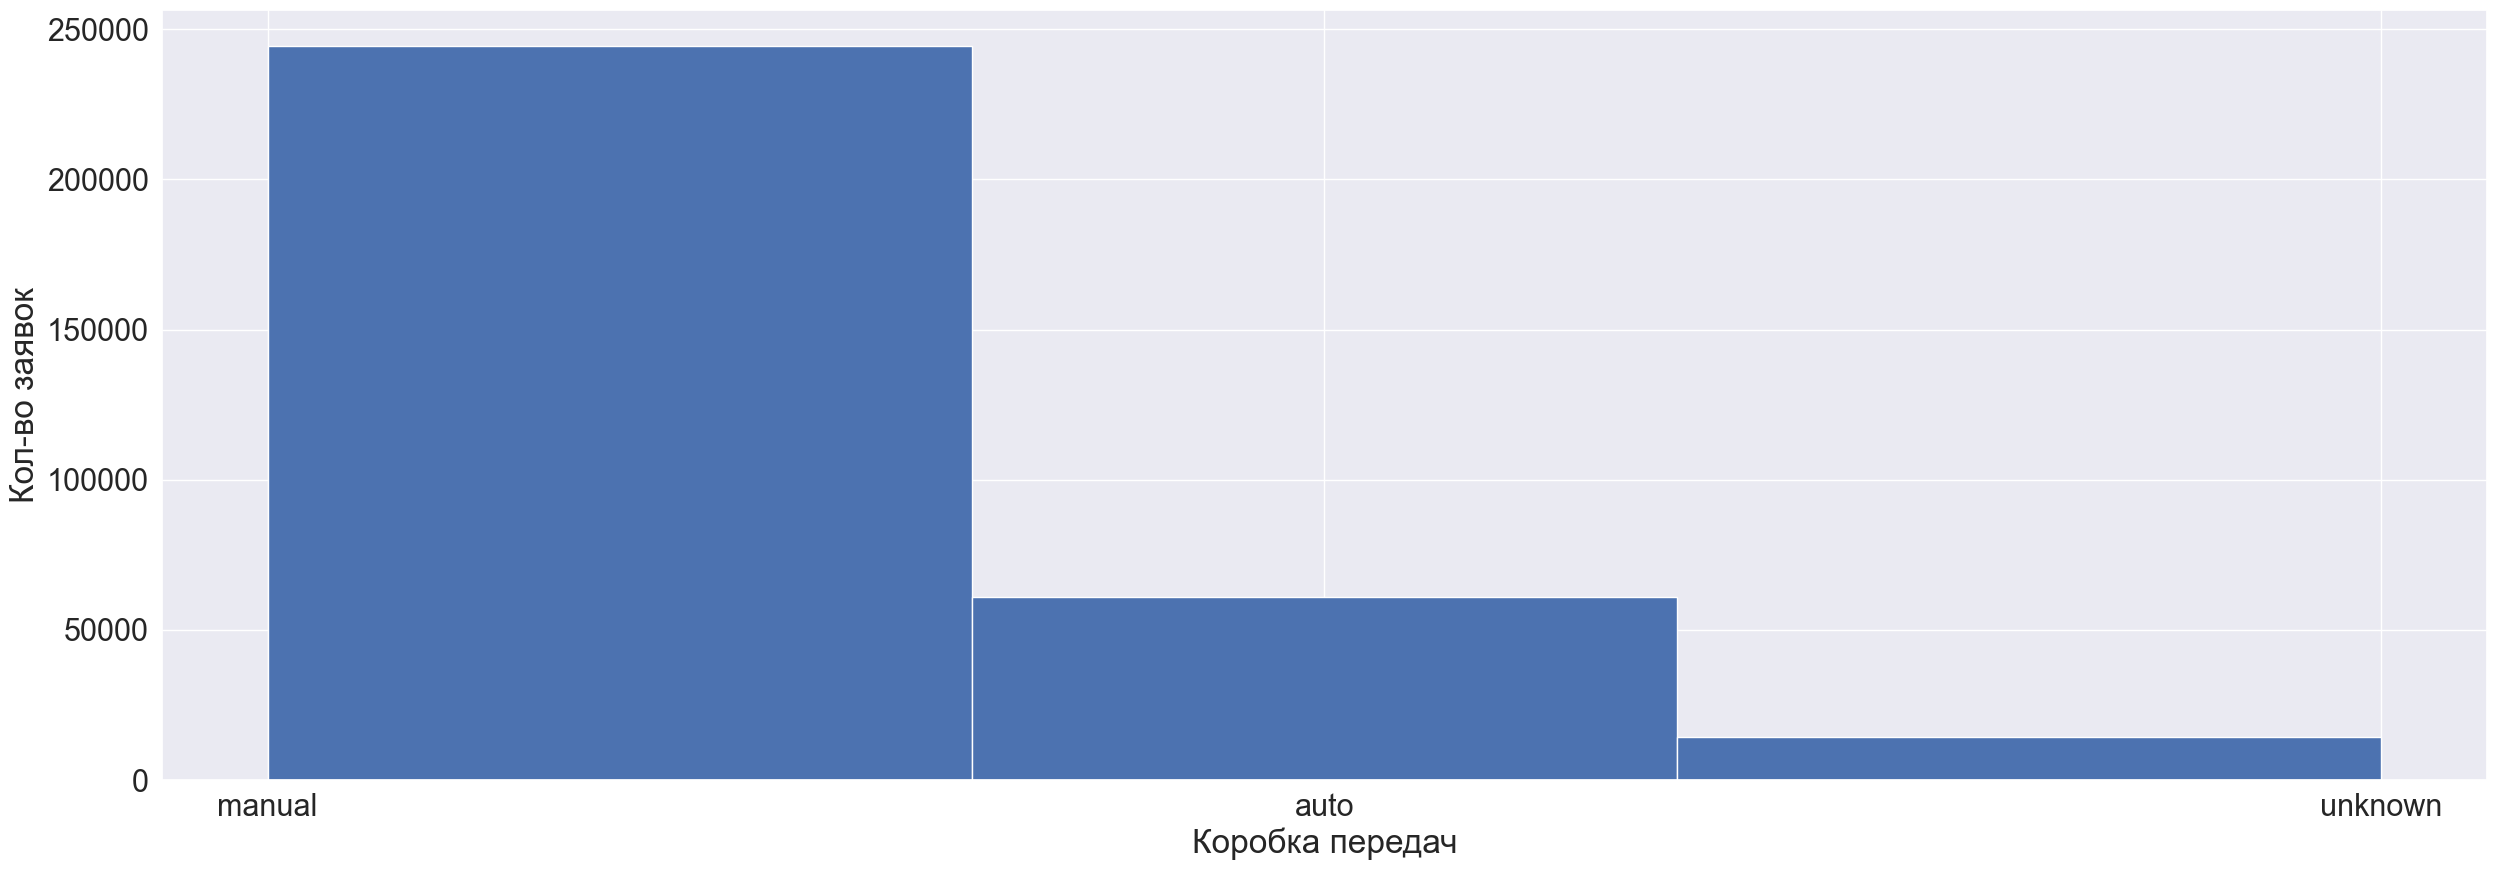

In [146]:
# заполним пропуски и выведем гистрограмму
data[data['Gearbox'].isna()] = data[data['Gearbox'].isna()].fillna('unknown')
data_analize(data, 1, 'Gearbox', 3, 'Коробка передач', 'Кол-во заявок', 0)

Кол-во пустых значений: 0


count     319341
unique         3
top           no
freq      230925
Name: Repaired, dtype: object

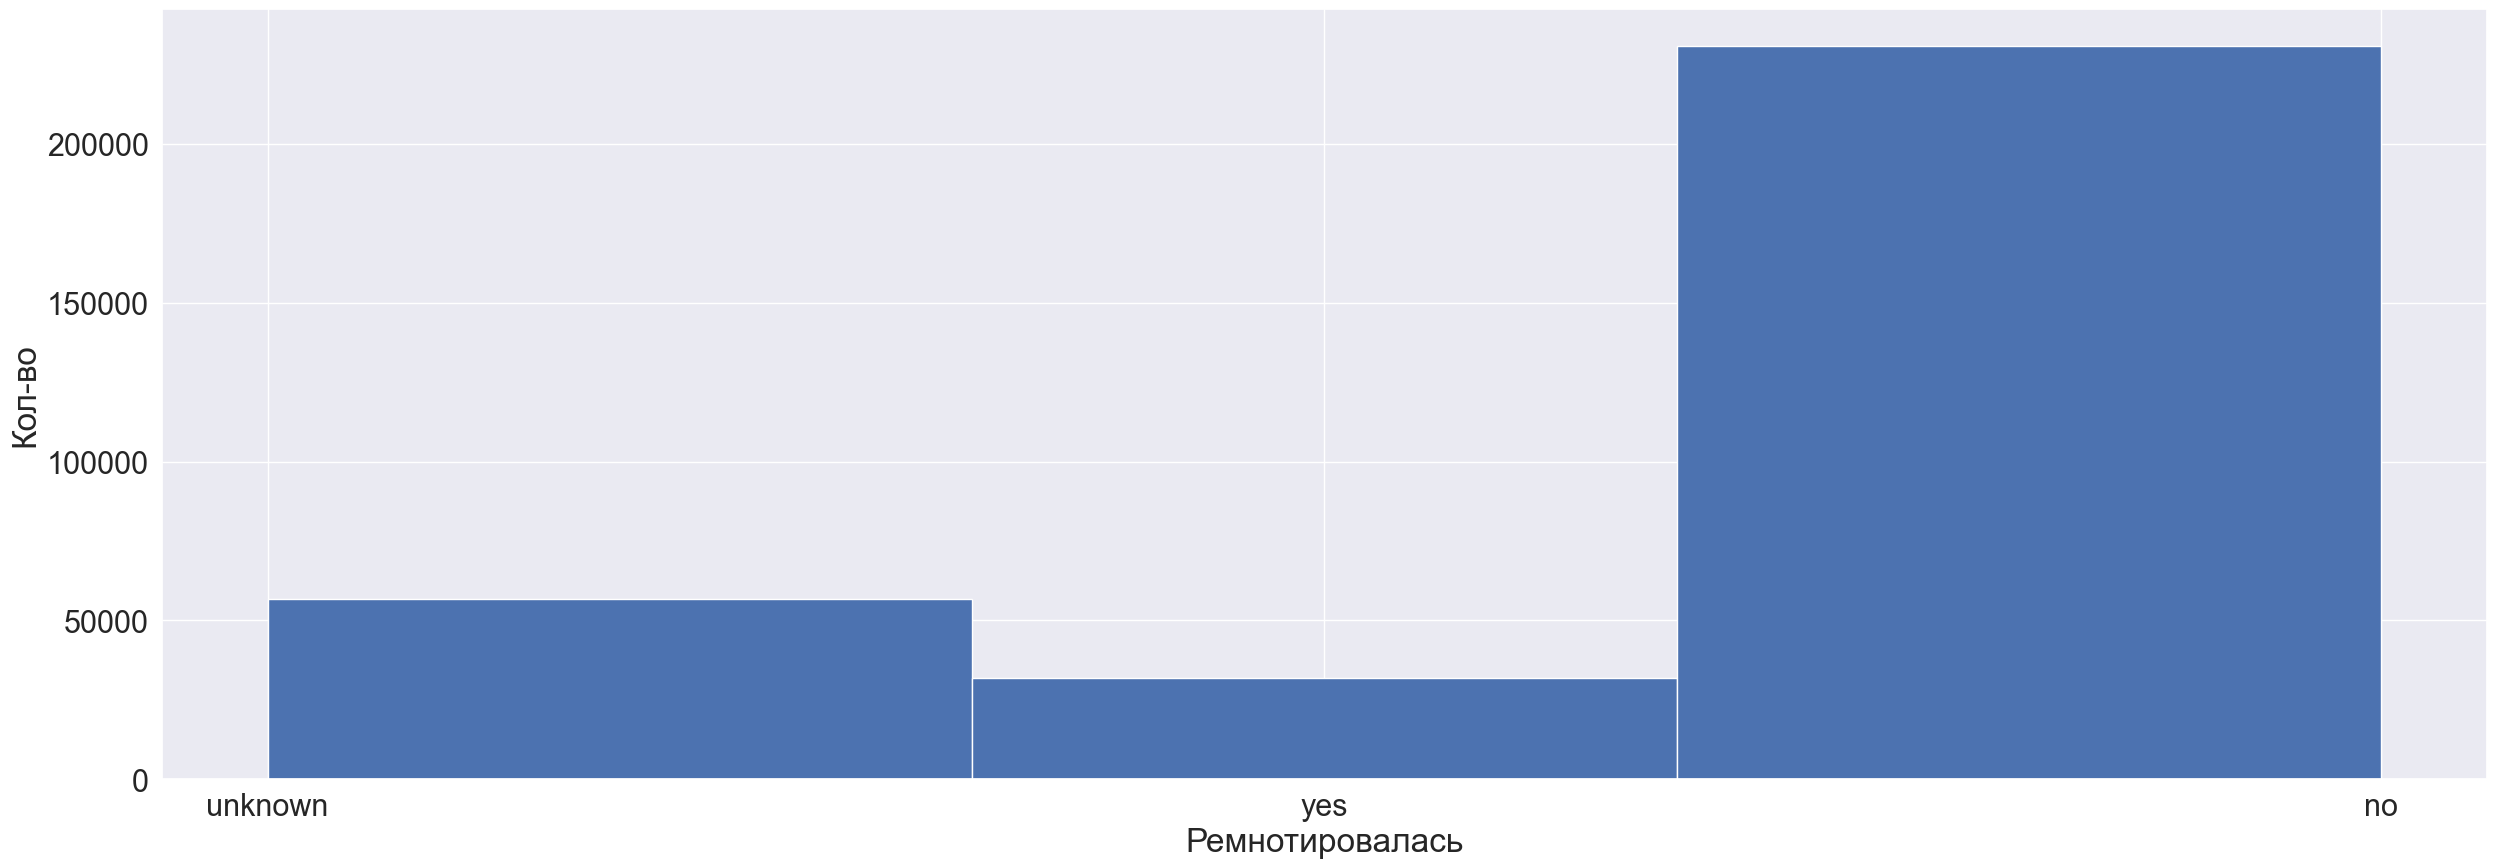

In [147]:
# заполним пропуски и выведем гистрограмму
data[data['Repaired'].isna()] = data[data['Repaired'].isna()].fillna('unknown')
data_analize(data, 1, 'Repaired', 3, 'Ремнотировалась', 'Кол-во', 0)

Выведем матрицу корреляции для числовых признаков.

C:\Users\User\AppData\Local\Temp\ipykernel_12884\5316553.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr().round(2)


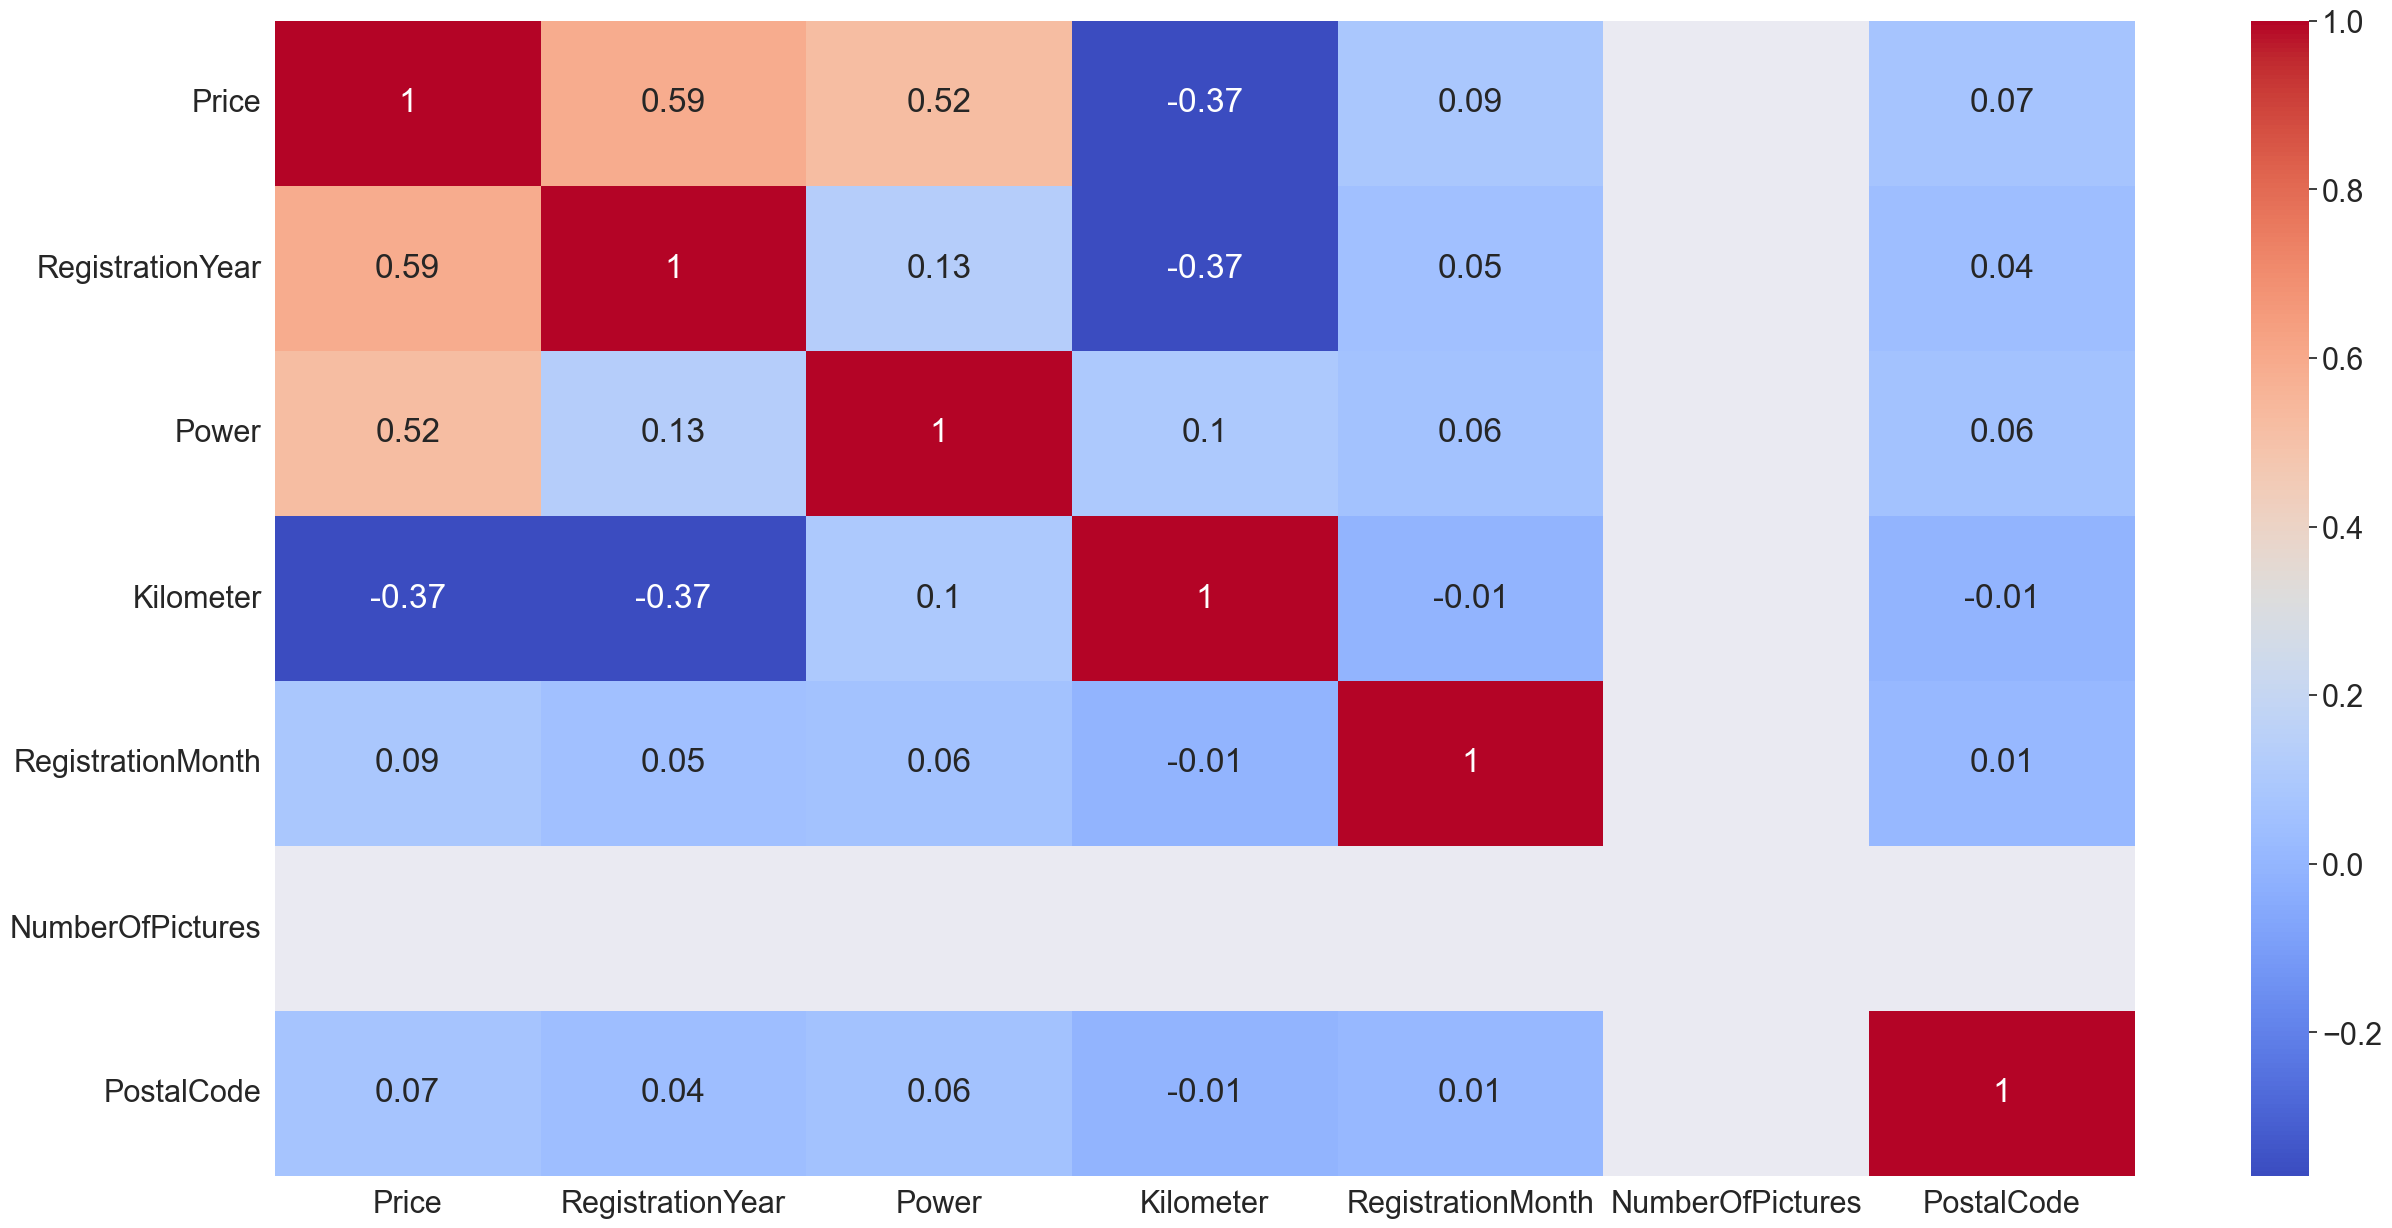

In [148]:
corr_matrix = data.corr().round(2)
sns.set(rc={"figure.figsize":(30, 15)}, font_scale=2)
sns.heatmap(corr_matrix, annot = True, fmt='.2g',cmap= 'coolwarm')
sns.set(rc={"figure.figsize":(3, 3)}, font_scale=2)

Можно выделить признаки Год регистрации, Мощность (л.с), пробег.

Для начала посмотрим какое кол-во заявок было в зависимости от года, а так же на цену.

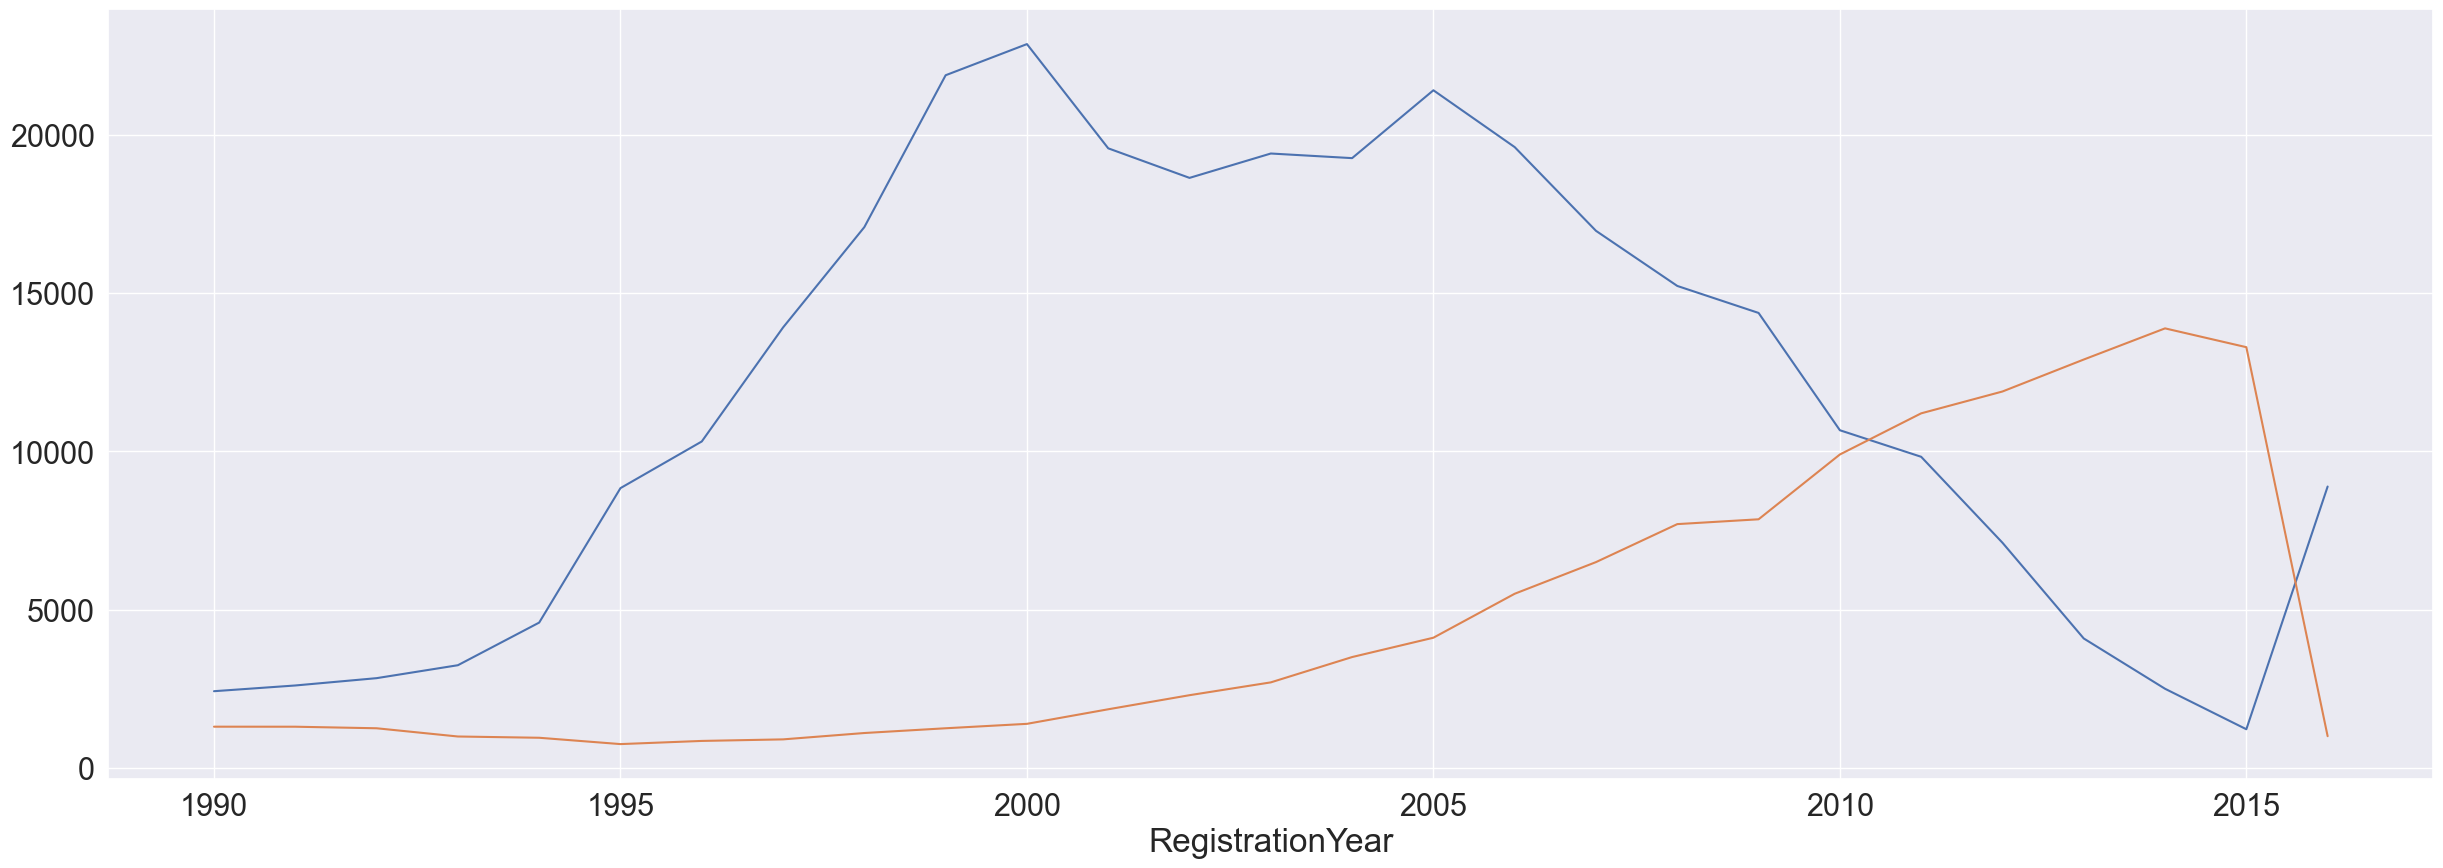

In [149]:
sns.set(rc={"figure.figsize":(30, 10)}, font_scale=2)
data.groupby('RegistrationYear')['RegistrationYear'].count().plot()
data.groupby('RegistrationYear')['Price'].median().plot()
plt.show()

С 2000-х годов начал происходить спад по количеству заявок на продажу автомобилей и так до 2015 года с небольшим кол-вом повышения заявок в к 2005 году.

Цена от года к году возрастала. 2015 год стал радикальным, когда началось резкое падение цены и точка минимума по количеству заявок на продажу.

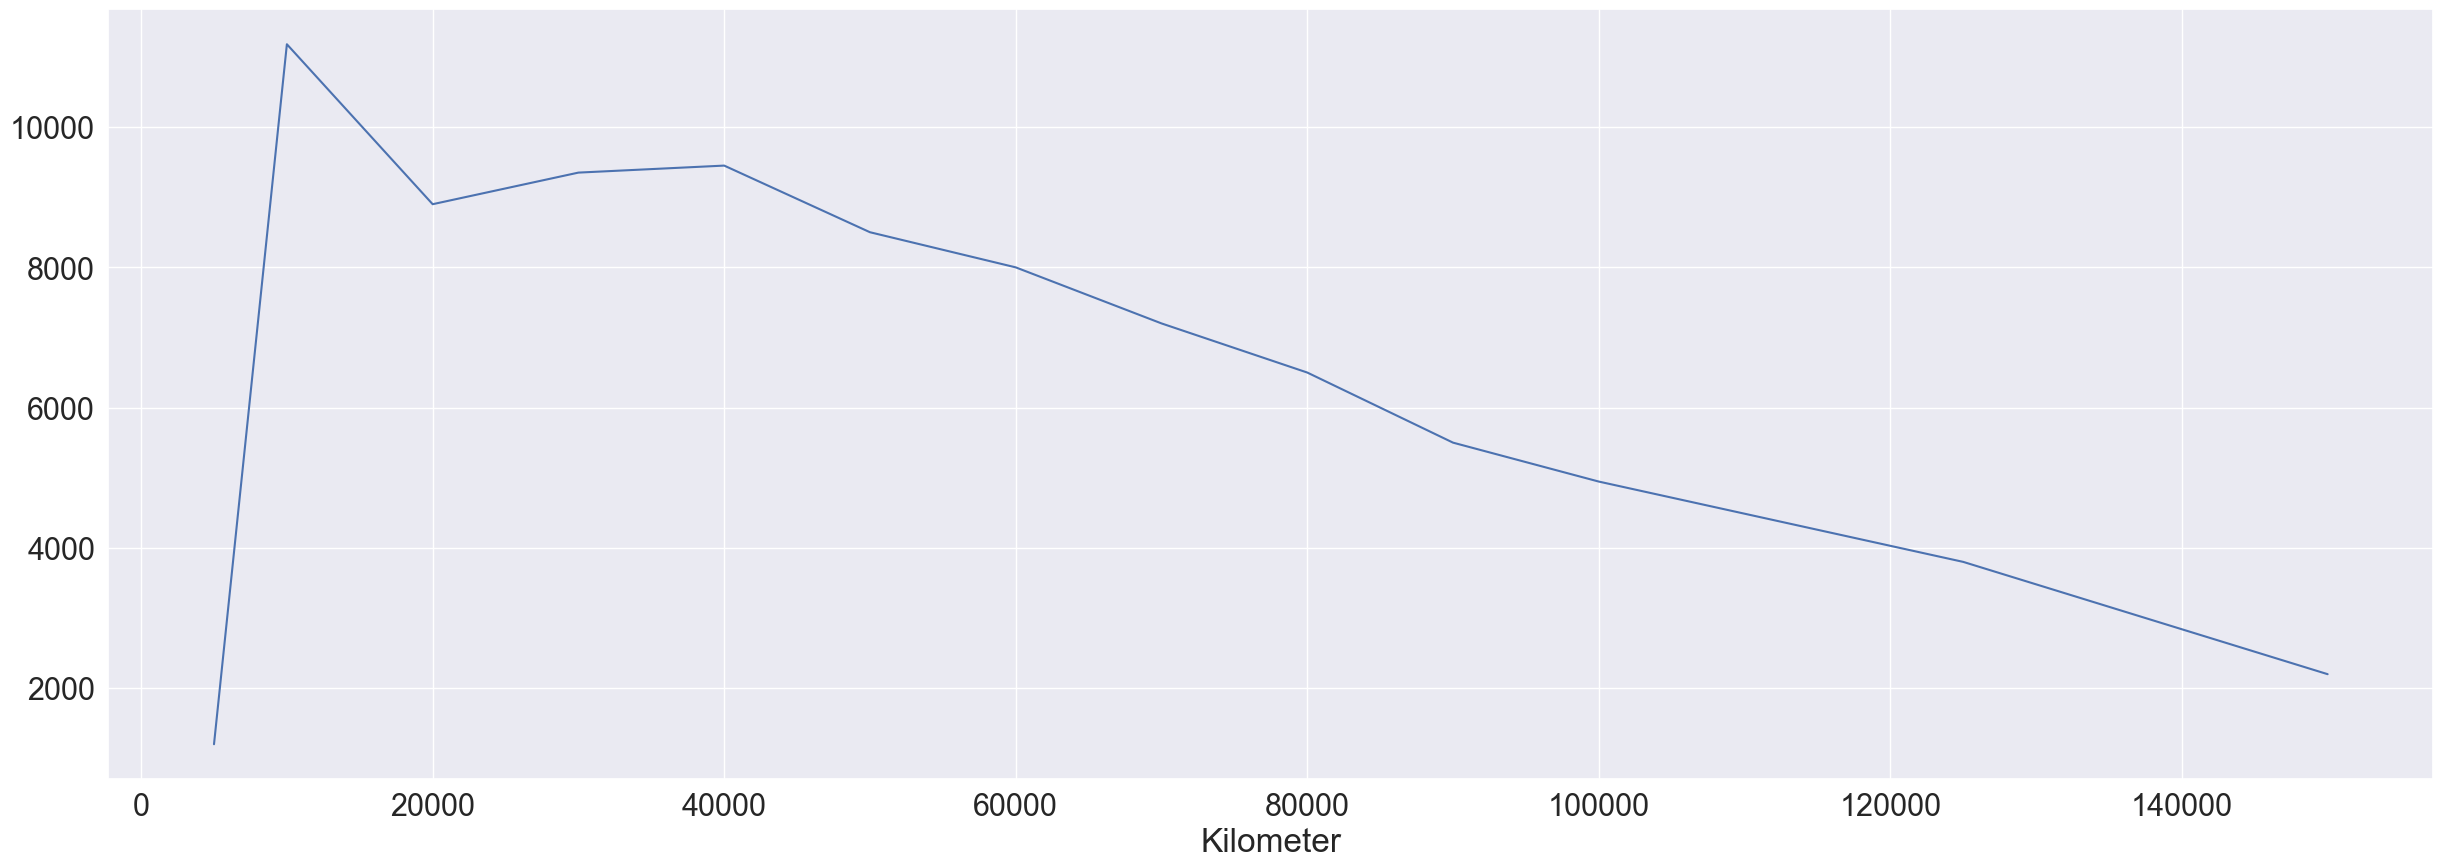

In [150]:
data.groupby('Kilometer')['Price'].median().plot()
plt.show()

Чем выше пробег, тем ниже цена отсюда и отрицательная корреляция.

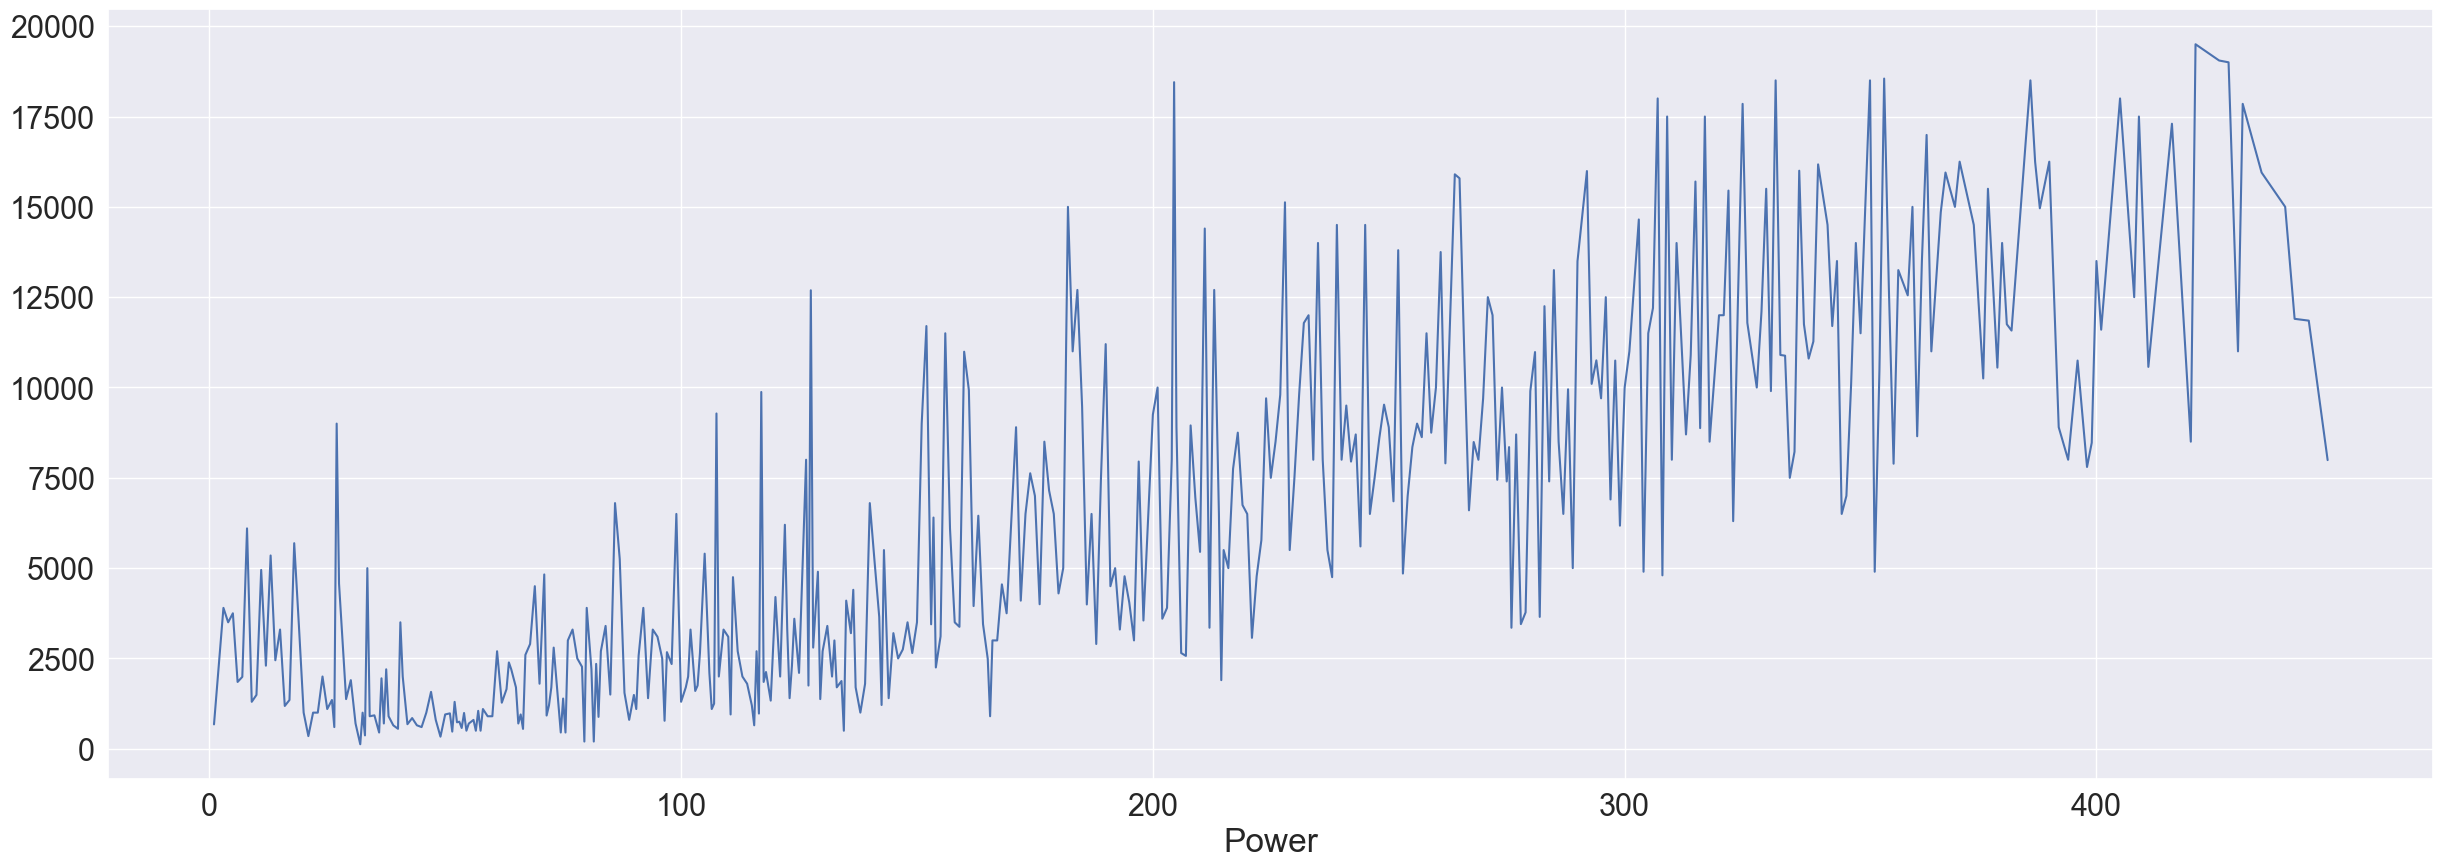

In [151]:
data.groupby('Power')['Price'].median().plot()
plt.show()

Мощность двигателя является важным показателем в формировании цены, но не единственным. На графике наблюдается рост, но с частыми скачками.

Очевидно, что стоимость автомобиля может зависеть от его состояния, т.е был он в ремонте или нет.

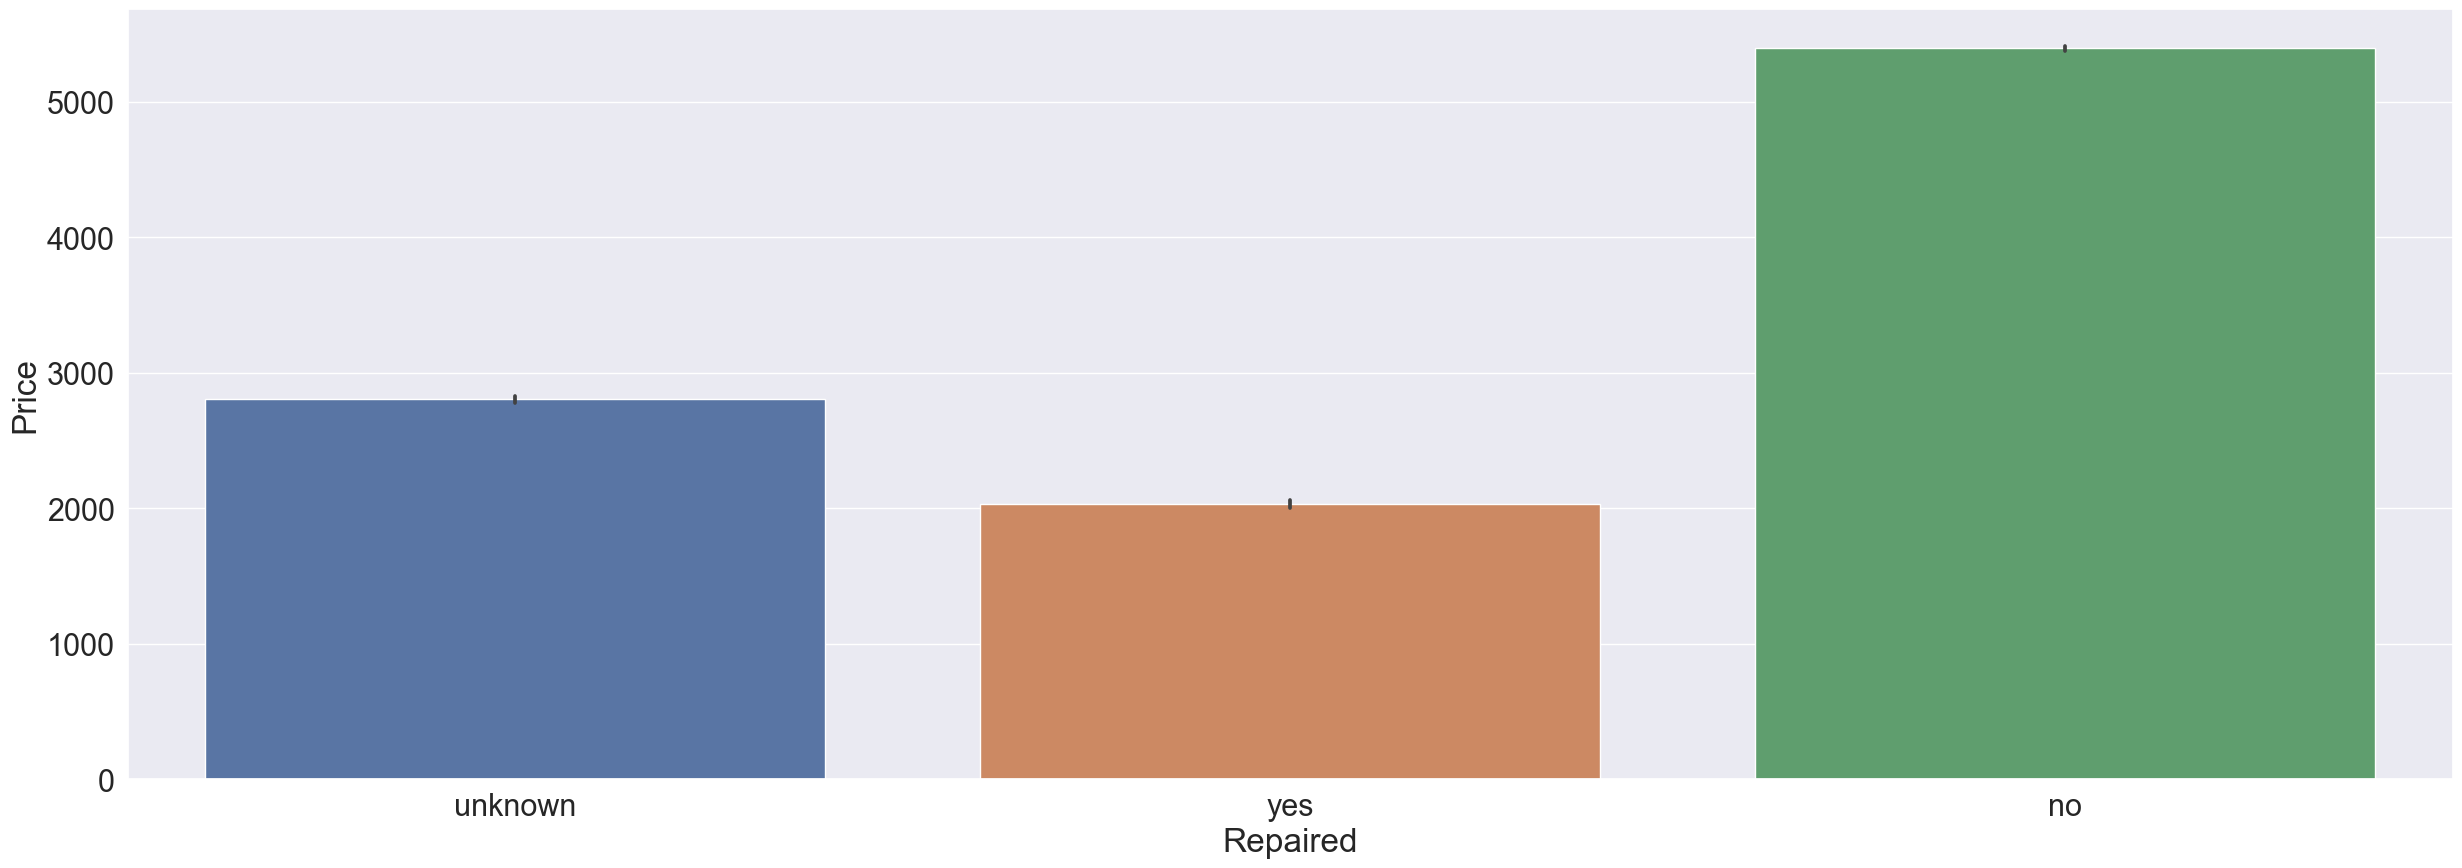

In [152]:
sns.barplot(x=data['Repaired'], y=data['Price'])
plt.show()

Предположим, что с автоматической коробкой передач цена выше.

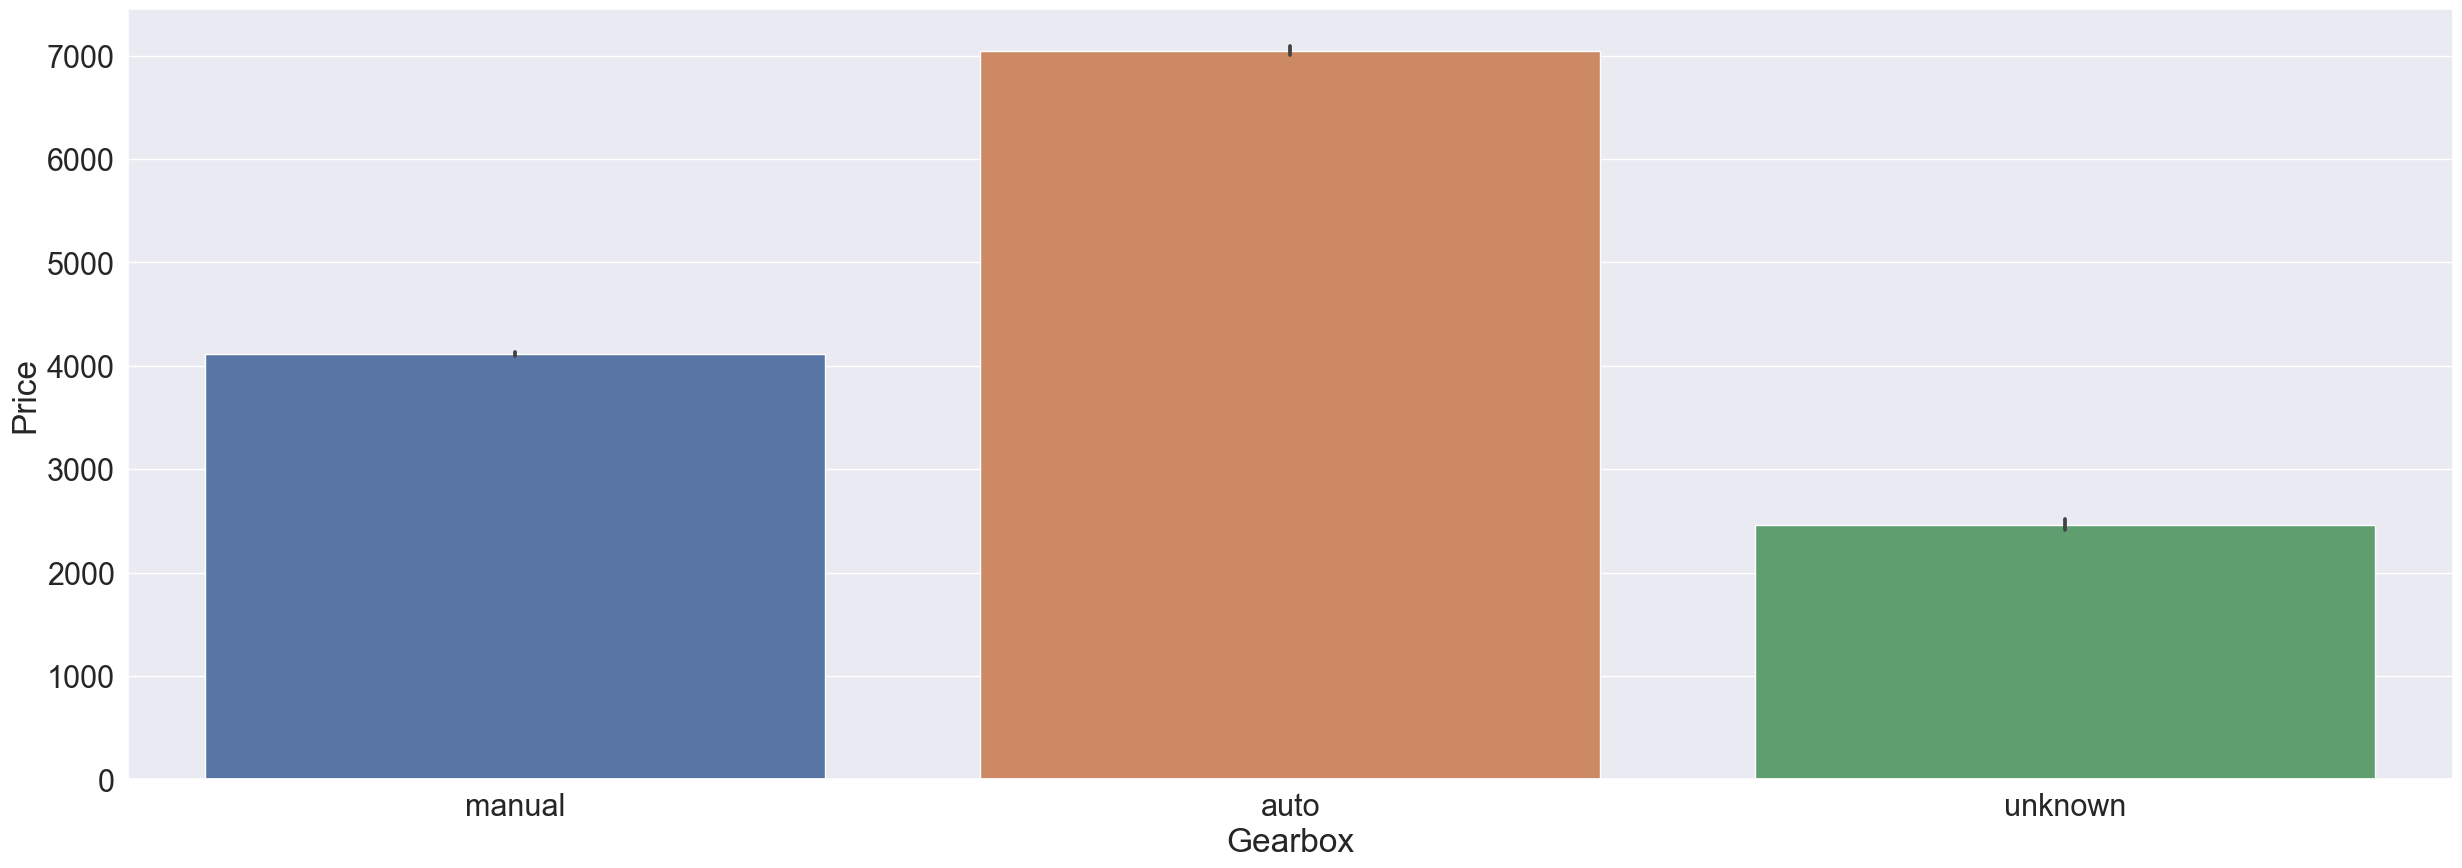

In [153]:
sns.barplot(x=data['Gearbox'], y=data['Price'])
plt.show()

А как насчет марки машины и модели машины? Некоторые марки зарекомендовали себя, что само сабой повлияло и на цену.

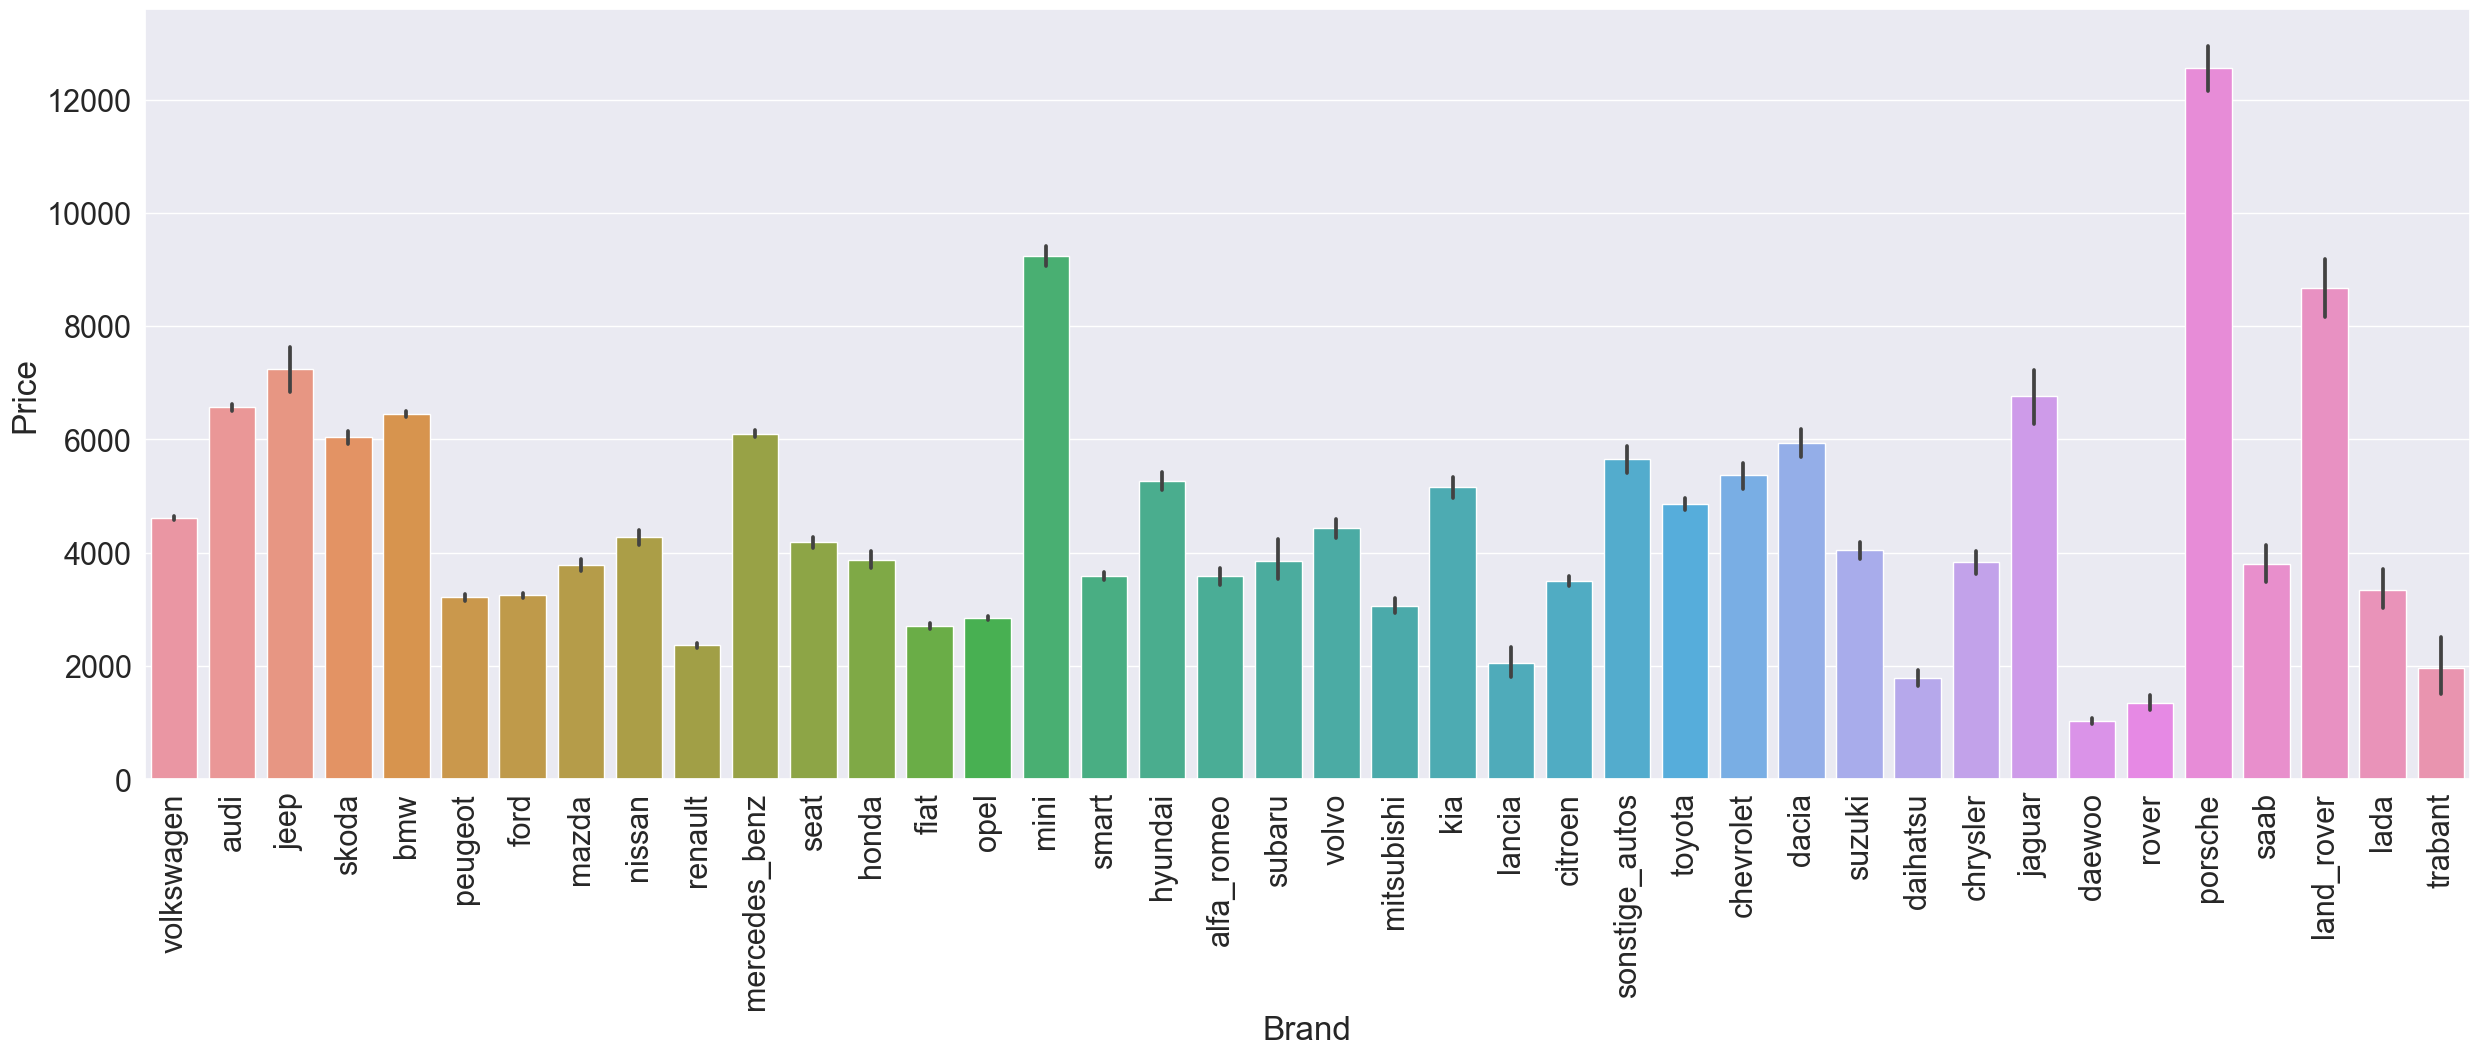

In [154]:
sns.barplot(x=data['Brand'], y=data['Price'])
plt.xticks(rotation=90)
plt.show()

### Вывод

В датасете присутствовали нулевые значения у целевого признака, а так же у числовых признаков. В некоторых случаях данные значения были заменены медианными значениями по группировке из трех других признаков, а в некоторых полностью удалены - это касается целевого признака.

В категориальных признаках так же были пропуски, они заменены заглушками **unknown** т.к мы не можем сказать какая комплектация автомобиля была у владельца.

Кроме нулевых значений и пропусков в данных присутствовали аномальные значения, которые в дальнейшем были отсечены.

Стоимость автомобиля зависит от:

* Модели и марки
* Пробега
* Коробки передач
* Была ли она в ремонте
* Мощьность двигателя

## Обучение моделей

In [155]:
# удалим неинформативные признаки
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [156]:
# Выведем числовые признаки
numerical_features = data.drop(['Price'], axis=1).select_dtypes(include='number').columns.tolist()
print(f'Числовые признаки ({len(numerical_features)}):', '\n')
print(numerical_features)

Числовые признаки (4): 

['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']


In [157]:
# Выведем категориальные признаки
categorical_features = data.select_dtypes(exclude='number').columns.tolist()
print(f'Категориальные признаки ({len(categorical_features)}):', '\n')
print(categorical_features)

Категориальные признаки (6): 

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


In [158]:
# Разобьем данные на трейновую и валидационную выборку и тестовую
features_train, features_valid, target_train, target_valid = train_test_split(
    data.drop(['Price'], axis=1), data['Price'], test_size=0.4, random_state=0)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=0)

In [159]:
scaler = StandardScaler()
scaler.fit(features_train[numerical_features])
      
features_train[numerical_features] = scaler.transform(features_train[numerical_features])
features_valid[numerical_features] = scaler.transform(features_valid[numerical_features])
features_test[numerical_features] = scaler.transform(features_test[numerical_features])

In [160]:
# используем порядковое кодирования для категориальных переменных
ordinal = OrdinalEncoder() 

ordinal_features_train = pd.concat([
    pd.DataFrame(ordinal.fit_transform(features_train[categorical_features]), columns=categorical_features).reset_index(drop=True), 
    features_train[numerical_features].reset_index(drop=True)], 
    sort=False, axis=1)

ordinal_features_valid = pd.concat([
    pd.DataFrame(ordinal.transform(features_valid[categorical_features]), columns=categorical_features).reset_index(drop=True), 
    features_valid[numerical_features].reset_index(drop=True)], 
    sort=False, axis=1) 

ordinal_features_test = pd.concat([
    pd.DataFrame(ordinal.transform(features_test[categorical_features]), columns=categorical_features).reset_index(drop=True), 
    features_test[numerical_features].reset_index(drop=True)], 
    sort=False, axis=1)


In [161]:
# прямое кодирование для линейной модели
ohe = OneHotEncoder(handle_unknown='ignore')

ohe_features_train = pd.concat([
    pd.DataFrame(ohe.fit_transform(features_train[categorical_features]).toarray()).reset_index(drop=True), 
    features_train[numerical_features].reset_index(drop=True)], 
    sort=False, axis=1)

ohe_features_valid = pd.concat([
    pd.DataFrame(ohe.transform(features_valid[categorical_features]).toarray()).reset_index(drop=True), 
    features_valid[numerical_features].reset_index(drop=True)], 
    sort=False, axis=1) 

ohe_features_test = pd.concat([
    pd.DataFrame(ohe.transform(features_test[categorical_features]).toarray()).reset_index(drop=True), 
    features_test[numerical_features].reset_index(drop=True)], 
    sort=False, axis=1)


In [162]:
%%time
# CatBoost
model = CatBoostRegressor(loss_function='RMSE', random_state=0)

params = {
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'iterations':[100]
}
grid_search_result = model.grid_search(params, X=ordinal_features_train, y=target_train, plot=True)

#model.fit(ordinal_features_train, target_train, verbose=10)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6304.2892611	test: 6307.3151084	best: 6307.3151084 (0)	total: 21.1ms	remaining: 2.09s
1:	learn: 6153.3687921	test: 6156.4854436	best: 6156.4854436 (1)	total: 33.6ms	remaining: 1.65s
2:	learn: 6006.4935018	test: 6009.8856552	best: 6009.8856552 (2)	total: 45.3ms	remaining: 1.47s
3:	learn: 5864.0420367	test: 5867.1139458	best: 5867.1139458 (3)	total: 55.4ms	remaining: 1.33s
4:	learn: 5729.6504762	test: 5733.1290225	best: 5733.1290225 (4)	total: 66.3ms	remaining: 1.26s
5:	learn: 5597.9266938	test: 5601.5157712	best: 5601.5157712 (5)	total: 77.6ms	remaining: 1.22s
6:	learn: 5470.9518484	test: 5474.9390568	best: 5474.9390568 (6)	total: 87.7ms	remaining: 1.17s
7:	learn: 5348.3862597	test: 5352.5777842	best: 5352.5777842 (7)	total: 99ms	remaining: 1.14s
8:	learn: 5230.9096049	test: 5235.5141894	best: 5235.5141894 (8)	total: 111ms	remaining: 1.12s
9:	learn: 5115.5925223	test: 5119.9134952	best: 5119.9134952 (9)	total: 121ms	remaining: 1.09s
10:	learn: 5003.3577123	test: 5007.6759678	b

In [163]:
predictions = model.predict(ordinal_features_valid)
rmse = mean_squared_error(target_valid, predictions) ** 0.5

metrics = pd.DataFrame({'Модель': 'CatBoostRegressor', 'RMSE': [rmse], 'Время обуч': '~2.9 сек', 'Время предск.': '~16 мс.'})

In [164]:
lgb_train = lgb.Dataset(ordinal_features_train, target_train)
lgb_eval = lgb.Dataset(ordinal_features_valid, target_valid, reference=lgb_train)

In [165]:
%%time
# lightGBM
params = {
    'metric':{'rmse'},
    'num_leaves': 4,
    'verbose': 10,
    'num_threads':2,
    #'num_iterations':100,
    'learnnig_rage': 0.05,
    'random_state': 0
}
modelGBM = lgb.train(params,
                  train_set=lgb_train)

[LightGBM] [Warning] Unknown parameter: learnnig_rage
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.743907
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.158329
[LightGBM] [Debug] init for col-wise cost 0.003417 seconds, init for row-wise cost 0.006188 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 191604, number of used features: 10
[LightGBM] [Info] Start training from score 4603.786612
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 2
[LightGBM] [Debug] Trained a tree with leaves = 4 and depth = 3
[LightGBM] [Debug] Trained a tree with l

In [166]:
%%time

predictions = modelGBM.predict(ordinal_features_valid)
rmse = mean_squared_error(target_valid, predictions) ** 0.5
print(f'RMSE: {rmse}')

RMSE: 1950.9570339812378
CPU times: total: 234 ms
Wall time: 124 ms


In [167]:
metrics =  pd.concat([
    metrics, 
    pd.DataFrame({'Модель': 'lightGBM', 'RMSE': [rmse], 'Время обуч': '~1.34 сек', 'Время предск.': '~149 мс.'})
])

In [168]:
%%time
model = XGBRegressor(
    num_parallel_tree=2, 
    max_leaves=4, 
    n_jobs=2, 
    Learning_rate=0.05,
    random_state=0)

model.fit(
    ordinal_features_train, 
    target_train,
    #eval_set = [(ordinal_features_valid, target_valid)],
    eval_metric='rmse'
)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[15:41:44] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "Learning_rate" } are not used.

CPU times: total: 25 s
Wall time: 12.9 s


XGBRegressor(Learning_rate=0.05, base_score=0.5, booster='gbtree',
             callbacks=None, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=1, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=2,
             num_parallel_tree=2, predictor='auto', ...)

In [169]:
%%time

predictions = model.predict(ordinal_features_valid)
rmse = mean_squared_error(target_valid, predictions) ** 0.5
print(f'RMSE: {rmse}')

RMSE: 1552.9284523272609
CPU times: total: 281 ms
Wall time: 149 ms


In [170]:
metrics =  pd.concat([
    metrics, 
    pd.DataFrame({'Модель': 'XGBRegressor', 'RMSE': [rmse], 'Время обуч': '~35 сек', 'Время предск.':'248 мс'})
])

In [171]:
%%time
model = LinearRegression()
model.fit(ohe_features_train, target_train)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


CPU times: total: 23 s
Wall time: 10.3 s


LinearRegression()

In [172]:
%%time

predictions = model.predict(ohe_features_valid)

rmse = mean_squared_error(target_valid, predictions) ** 0.5
print(f'RMSE: {rmse}')

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


RMSE: 2351.4680584575462
CPU times: total: 266 ms
Wall time: 270 ms


In [173]:
metrics =  pd.concat([
    metrics, 
    pd.DataFrame({'Модель': 'LinearRegression', 'RMSE': [2351], 'Время обуч': '~20-30 сек.', 'Время предск.':'~270 мс'})
])

## Анализ моделей

In [174]:
metrics

,Модель,RMSE,Время обуч,Время предск.
0,CatBoostRegressor,1627.593735,~2.9 сек,~16 мс.
0,lightGBM,1950.957034,~1.34 сек,~149 мс.
0,XGBRegressor,1552.928452,~35 сек,248 мс
0,LinearRegression,2351.000000,~20-30 сек.,~270 мс


Исходя из критериев, которые важны заказчику:

* RMSE < 2500 
* качество предсказания;
* время обучения модели;
* время предсказания модели.

Подходит модель lightGBM. Проверим ее качество на тестовой выборке.

In [175]:
predictions = modelGBM.predict(ordinal_features_test)

rmse = mean_squared_error(target_test, predictions) ** 0.5
print(f'RMSE: {rmse}')

RMSE: 1938.0900269227964


### Вывод

Из четырех модели была выбрана lightGBM и проверена на тестовых данных. Данная модель походит под критерии отбора.

### Общий вывод

Во входном датасете присутствовали нулевые значения, пропуски и аномальные значения. Пропуски были заполнены, а аномальные значения отрезаны. Кроме того, в результате анализа выявлены параметры влияющие на стоимость автомобиля:

* Модель и марка
* Пробег
* Коробка передач
* Была ли машина в ремонте
* Мощьность двигателя

Категориальные признаки перекодированы, а числовые приведены к единому стандарту. Из четырех моделей:

In [176]:
metrics

,Модель,RMSE,Время обуч,Время предск.
0,CatBoostRegressor,1627.593735,~2.9 сек,~16 мс.
0,lightGBM,1950.957034,~1.34 сек,~149 мс.
0,XGBRegressor,1552.928452,~35 сек,248 мс
0,LinearRegression,2351.000000,~20-30 сек.,~270 мс


Выбрана лучшая модель, исходя из следующих критериев:

* RMSE < 2500 
* качество предсказания;
* время обучения модели;
* время предсказания модели.

In [177]:
print(f'lightGBM RMSE: {rmse}')

lightGBM RMSE: 1938.0900269227964
